비트코인 가격 변동성 예측_GARCH(1,1) + LSTM

In [30]:
%pip install pyupbit
%pip install urllib3
%pip install --upgrade urllib3 six
%pip install requests
%matplotlib inline

%pip install keras_tuner
%pip install tensorflow  

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#from keras.models import Model, Sequential
from keras.layers import *
#from keras.utils.vis_utils import plot_model
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import math
import random
# from tensorflow.keras.layers import Input, LSTM, Dense
# from tensorflow.keras.models import Model
import keras_tuner as kt
#from keras_tuner import RandomSearch
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import Loss
#from sklearn.metrics import classification_report
import os
#from functools import partial
#from keras_tuner import RandomSearch, Objective, HyperParameters as hp
from keras_tuner import Hyperband, Objective, HyperParameters as hp
from keras_tuner import RandomSearch
from tensorflow.keras.losses import Loss

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import pyupbit
import pandas as pd  # pandas 라이브러리 추가
import warnings
warnings.filterwarnings("ignore")

ticker = 'KRW-BTC'
interval = 'minute240'
to = '2024-04-30 21:00'
count = 9559
data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)

# CSV 파일로 저장
data.to_csv('BTC_1.csv')
data

open        high         low       close  \
2019-12-21 01:00:00   8324000.0   8365000.0   8304000.0   8350000.0   
2019-12-21 05:00:00   8350000.0   8372000.0   8328000.0   8338000.0   
2019-12-21 09:00:00   8342000.0   8342000.0   8301000.0   8313000.0   
2019-12-21 13:00:00   8313000.0   8336000.0   8271000.0   8279000.0   
2019-12-21 17:00:00   8279000.0   8318000.0   8260000.0   8310000.0   
...                         ...         ...         ...         ...   
2024-04-30 13:00:00  90733000.0  90800000.0  89557000.0  89801000.0   
2024-04-30 17:00:00  89801000.0  90000000.0  87289000.0  87806000.0   
2024-04-30 21:00:00  87805000.0  88450000.0  87050000.0  87564000.0   
2024-05-01 01:00:00  87536000.0  87742000.0  85606000.0  85684000.0   
2024-05-01 05:00:00  85684000.0  87980000.0  85627000.0  87137000.0   

                          volume         value  
2019-12-21 01:00:00   217.172182  1.810151e+09  
2019-12-21 05:00:00   140.220142  1.169995e+09  
2019-12-21 09:00:00   216.799609  1.803141e+09  
2019-12-21 13:00:00   235.050319  1.951706e+09  
2019-12-21 17:00:00   194.615774  1.611698e+09  
...                          ...           ...  
2024-04-30 13:00:00   564.216567  5.082555e+10  
2024-04-30 17:00:00  2233.925204  1.975182e+11  
2024-04-30 21:00:00  1440.776009  1.263755e+11  
2024-05-01 01:00:00  1167.797145  1.012467e+11  
2024-05-01 05:00:00   985.348435  8.556360e+10  

[9559 rows x 6 columns]

In [33]:
# 데이터를 불러오기
data = pd.read_csv('BTC_1.csv')

#새로운 열 추가
data.columns.values[0] = 'datetime'

print(data.shape)
print(data.info())

(9559, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9559 entries, 0 to 9558
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   datetime  9559 non-null   object 
 1   open      9559 non-null   float64
 2   high      9559 non-null   float64
 3   low       9559 non-null   float64
 4   close     9559 non-null   float64
 5   volume    9559 non-null   float64
 6   value     9559 non-null   float64
dtypes: float64(6), object(1)
memory usage: 522.9+ KB
None


In [34]:
# day피처를 시계열 피처로 변환
data['datetime'] = pd.to_datetime(data['datetime'])

# datetime 데이터프레임의 index로 설정
data.index = data['datetime']
data.set_index('datetime', inplace=True)
data.head()

# CSV 파일로 저장
data.to_csv('BTC_2.csv')

data.describe()

open          high           low         close        volume  \
count  9.559000e+03  9.559000e+03  9.559000e+03  9.559000e+03   9559.000000   
mean   3.914586e+07  3.947764e+07  3.881651e+07  3.915315e+07   1079.957302   
std    2.180065e+07  2.200000e+07  2.160226e+07  2.180348e+07   1094.838539   
min    6.130000e+06  6.460000e+06  5.489000e+06  6.123000e+06     43.459334   
25%    2.270400e+07  2.280400e+07  2.257300e+07  2.270600e+07    435.749693   
50%    3.733300e+07  3.762900e+07  3.703700e+07  3.734000e+07    761.616077   
75%    5.311250e+07  5.367000e+07  5.270000e+07  5.312650e+07   1341.314399   
max    1.047800e+08  1.050000e+08  1.042150e+08  1.047560e+08  20046.131816   

              value  
count  9.559000e+03  
mean   4.599861e+10  
std    5.828591e+10  
min    4.689780e+08  
25%    1.105910e+10  
50%    2.636282e+10  
75%    5.810952e+10  
max    7.841618e+11

VIX 지수

In [35]:
import pandas as pd
df_vix = pd.read_csv("CBOE_VIX.csv", encoding='UTF-8')

df_vix

# '날짜'와 'CLOSE'를 제외한 나머지 열 삭제
df_vix = df_vix[['Date', 'Price']]
df_vix.to_csv("CBOE_VIX_1.csv", encoding='utf-8-sig', index=False)

import pandas as pd

df_vix.rename(columns={'Date': 'DATE'}, inplace=True)
df_vix.rename(columns={'Price': 'CBOE_VIX'}, inplace=True)

print(df_vix.head())

df_vix.to_csv("CBOE_VIX_2.csv", encoding='utf-8-sig', index=False)

df_vix = pd.read_csv("CBOE_VIX_2.csv", encoding='UTF-8')

# 날짜를 오래된 순으로 정렬
df_vix['DATE'] = pd.to_datetime(df_vix['DATE'])  # 날짜 형식으로 변환
df_vix = df_vix.sort_values(by='DATE', ascending=True)

# 정렬된 데이터를 CSV 파일로 저장
df_vix.to_csv("CBOE_VIX_3.csv", encoding='utf-8-sig', index=False)

# 'DATE' 열을 datetime 타입으로 변환
df_vix['DATE'] = pd.to_datetime(df_vix['DATE'])

import pandas as pd

# CSV 파일 로드
df_vix = pd.read_csv("CBOE_VIX_3.csv", parse_dates=['DATE'], dayfirst=True, encoding='UTF-8')
# '.'을 NaN으로 대체
df_vix.replace('.', pd.NA, inplace=True)

# 'ffill'을 사용하여 NaN 값을 앞의 값으로 채움
df_vix.fillna(method='ffill', inplace=True)

# 결과 확인
print(df_vix.head())

# CSV 파일로 저장
df_vix.to_csv('CBOE_VIX_4.csv')

import pandas as pd

# CSV 파일 불러오기
df_vix = pd.read_csv("CBOE_VIX_4.csv", parse_dates=['DATE'])

# 모든 날짜를 포함하는 새로운 DataFrame 생성
all_dates = pd.date_range(start='2019-12-20', end='2024-05-02', freq='D')
df_full = pd.DataFrame({'DATE': all_dates})

# 원래 데이터와 새로운 DataFrame 병합
df_vix_merged = pd.merge(df_full, df_vix, on='DATE', how='left')

# 결과 확인
print(df_vix_merged.head())

# CSV 파일로 저장
df_vix_merged.to_csv('CBOE_VIX_5.csv', index=False)

import pandas as pd

# CSV 파일을 불러옵니다.
df_vix_merged = pd.read_csv('CBOE_VIX_5.csv')

# 열을 삭제합니다.
df_vix_merged.drop('Unnamed: 0', axis=1, inplace=True)

# 결과를 확인합니다.
print(df_vix_merged.head())

# CSV 파일로 저장
df_vix_merged.to_csv('CBOE_VIX_6.csv')

df_vix_merged_2 = pd.read_csv('CBOE_VIX_6.csv')

# 'ffill'을 사용하여 NaN 값을 앞의 값으로 채움
df_vix_merged_2.fillna(method='ffill', inplace=True)

# 열을 삭제합니다.
df_vix_merged_2.drop('Unnamed: 0', axis=1, inplace=True)

# 결과 확인
print(df_vix_merged_2.head())

# CSV 파일로 저장
df_vix_merged_2.to_csv('CBOE_VIX_7.csv')

import pandas as pd

# VIX 지수 데이터 로드
df_vix_merged_3 = pd.read_csv('CBOE_VIX_7.csv')

# 새로운 데이터프레임 생성
df_vix_expand = pd.DataFrame(df_vix_merged_3)

# 시간 간격 설정
time_intervals = ['1:00 AM', '5:00 AM', '9:00 AM', '1:00 PM',
                  '5:00 PM', '9:00 PM']
new_rows=[]

for _, row in df_vix_expand.iterrows() :
    date = row['DATE'].split(' ')[0]  # 날짜 컬럼
    value = row['CBOE_VIX']  # VIX 지수 값 컬럼
    
    for time in time_intervals:
        # 새로운 행 생성
        new_row = {'datetime': f"{date} {time}", 'CBOE_VIX': value}
        new_rows.append(new_row)

# 새로운 행들을 포함하는 데이터프레임 생성
df_vix_expand = pd.DataFrame(new_rows)   

# 새로운 데이터프레임 확인
print(df_vix_expand.head())

# 결과를 CSV 파일로 저장
df_vix_expand.to_csv('CBOE_VIX_8.csv', index=False)

import pandas as pd

# CSV 파일 로드
df_vix_expand = pd.read_csv('CBOE_VIX_8.csv')

# 처음 6개 행 제거
df_vix_expand = df_vix_expand[6:]
# 마지막 10개 행 제거
df_vix_expand = df_vix_expand[:-10]

# 변경된 데이터프레임을 같은 파일에 다시 저장
df_vix_expand.to_csv('CBOE_VIX_9.csv', index=False)

import pandas as pd

# CSV 파일 불러오기
df_1 = pd.read_csv('BTC_2.csv')  # Bitcoin 가격 데이터가 있는 CSV 파일
df_CBOE_VIX_expand = pd.read_csv('CBOE_VIX_9.csv')  # VIX 데이터가 있는 CSV 파일

# 'datetime' 열을 기준으로 두 데이터프레임 병합
# how='inner'는 두 데이터프레임에 모두 존재하는 'datetime' 값에 대해서만 병합을 수행합니다.
# on='datetime'은 'datetime' 열을 병합의 기준으로 사용합니다.
df_1_CBOE_VIX_expand = pd.merge(df_1, df_CBOE_VIX_expand, how='inner', on='datetime')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
df_1_CBOE_VIX_expand.to_csv('BTC_CBOE_VIX.csv', index=False)

import pandas as pd

# CSV 파일 불러오기
df_1 = pd.read_csv('BTC_2.csv')  # Bitcoin 가격 데이터가 있는 CSV 파일
df_CBOE_VIX_expand = pd.read_csv('CBOE_VIX_9.csv')  # VIX 데이터가 있는 CSV 파일

# 필요한 경우, datetime 열의 형식을 통일합니다.
df_1['datetime'] = pd.to_datetime(df_1['datetime'])
df_CBOE_VIX_expand['datetime'] = pd.to_datetime(df_CBOE_VIX_expand['datetime'])

# 'datetime' 열을 기준으로 두 데이터프레임 병합
df_1_CBOE_VIX_expand = pd.merge(df_1, df_CBOE_VIX_expand, how='inner', on='datetime')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
df_1_CBOE_VIX_expand.to_csv('BTC_CBOE_VIX.csv', index=False)

         DATE  CBOE_VIX
0  05/02/2024     14.68
1  05/01/2024     15.39
2  04/30/2024     15.65
3  04/29/2024     14.67
4  04/26/2024     15.03
        DATE  CBOE_VIX
0 2019-12-20     12.51
1 2019-12-23     12.61
2 2019-12-24     12.67
3 2019-12-26     12.65
4 2019-12-27     13.43
        DATE  Unnamed: 0  CBOE_VIX
0 2019-12-20         0.0     12.51
1 2019-12-21         NaN       NaN
2 2019-12-22         NaN       NaN
3 2019-12-23         1.0     12.61
4 2019-12-24         2.0     12.67
         DATE  CBOE_VIX
0  2019-12-20     12.51
1  2019-12-21       NaN
2  2019-12-22       NaN
3  2019-12-23     12.61
4  2019-12-24     12.67
         DATE  CBOE_VIX
0  2019-12-20     12.51
1  2019-12-21     12.51
2  2019-12-22     12.51
3  2019-12-23     12.61
4  2019-12-24     12.67
             datetime  CBOE_VIX
0  2019-12-20 1:00 AM     12.51
1  2019-12-20 5:00 AM     12.51
2  2019-12-20 9:00 AM     12.51
3  2019-12-20 1:00 PM     12.51
4  2019-12-20 5:00 PM     12.51


KOSPI200 지수

In [36]:
import pandas as pd
df_kospi = pd.read_csv("KOSPI200.csv", encoding='UTF-8')

# '날짜'와 'CLOSE'를 제외한 나머지 열 삭제
df_kospi = df_kospi[['Date', 'Price']]
df_kospi.to_csv("KOSPI200_1.csv", encoding='utf-8-sig', index=False)

df_kospi

import pandas as pd

df_kospi.rename(columns={'Date': 'DATE'}, inplace=True)
df_kospi.rename(columns={'Price': 'KOSPI200'}, inplace=True)

print(df_kospi.head())

df_kospi.to_csv("KOSPI200_2.csv", encoding='utf-8-sig', index=False)
df_kospi = pd.read_csv("KOSPI200_2.csv", encoding='UTF-8')

# 날짜를 오래된 순으로 정렬
df_kospi['DATE'] = pd.to_datetime(df_kospi['DATE'])  # 날짜 형식으로 변환
df_kospi = df_kospi.sort_values(by='DATE', ascending=True)

# 정렬된 데이터를 CSV 파일로 저장
df_kospi.to_csv("KOSPI200_3.csv", encoding='utf-8-sig', index=False)
# 'DATE' 열을 datetime 타입으로 변환
df_kospi['DATE'] = pd.to_datetime(df_kospi['DATE'])

import pandas as pd
import numpy as np

# 예제 데이터프레임 생성 
# '날짜'와 'KOSPI200' 열을 가진 데이터프레임을 가정
df_kospi = pd.read_csv("KOSPI200_3.csv", encoding='UTF-8')
df_kospi_2 = pd.DataFrame(df_kospi)

# '날짜' 열을 datetime 타입으로 변환
df_kospi_2['DATE'] = pd.to_datetime(df_kospi_2['DATE'])

# '날짜' 열을 인덱스로 설정
df_kospi_2.set_index('DATE', inplace=True)

# 시작 날짜와 종료 날짜 사이의 모든 날짜를 생성
all_dates = pd.date_range(start='2019-12-20', end='2024-05-02', freq='D')

# 생성된 날짜를 사용하여 데이터프레임 리샘플링 및 누락된 날짜 채우기
df_kospi_3 = df_kospi_2.reindex(all_dates, fill_value=np.nan)  # NaN 값으로 채움

# 인덱스에 이름 설정
df_kospi_3.index.name = 'DATE'
# CSV 파일로 저장하면서 인덱스 레이블을 포함
df_kospi_3.to_csv('KOSPI200_4.csv', index=True, index_label='DATE')

# 결과 확인
print(df_kospi_3.head())

# CSV 파일로 저장
df_kospi_3.to_csv('KOSPI200_4.csv')

import pandas as pd

# CSV 파일 로드
df_kospi_4 = pd.read_csv("KOSPI200_4.csv", parse_dates=['DATE'], dayfirst=True, encoding='UTF-8')

# 'ffill'을 사용하여 NaN 값을 앞의 값으로 채움
df_kospi_4.fillna(method='ffill', inplace=True)

# 결과 확인
print(df_kospi_4.tail())

# CSV 파일로 저장
df_kospi_4.to_csv('KOSPI200_5.csv')

import pandas as pd

# kospi200 지수 데이터 로드
df_kospi_5 = pd.read_csv('KOSPI200_5.csv')
# 새로운 데이터프레임 생성
df_kospi_6 = pd.DataFrame(df_kospi_5)

# 시간 간격 설정
time_intervals = ['1:00 AM', '5:00 AM', '9:00 AM', '1:00 PM',
                  '5:00 PM', '9:00 PM']

new_rows=[]

for _, row in df_kospi_6.iterrows() :
    date = row['DATE'].split(' ')[0]  # 날짜 컬럼
    value = row['KOSPI200']  # kospi200 지수 값 컬럼
    
    for time in time_intervals:
        # 새로운 행 생성
        new_row = {'datetime': f"{date} {time}", 'KOSPI200': value}
        new_rows.append(new_row)

# 새로운 행들을 포함하는 데이터프레임 생성
df_kospi_6 = pd.DataFrame(new_rows)   

# 새로운 데이터프레임 확인
print(df_kospi_6.head())

# 결과를 CSV 파일로 저장
df_kospi_6.to_csv('KOSPI200_6.csv', index=False)

import pandas as pd

# CSV 파일 로드
df_kospi_7 = pd.read_csv('KOSPI200_6.csv')

# 처음 6개 행 제거
df_kospi_7 = df_kospi_7[6:]
# 마지막 10개 행 제거
df_kospi_7 = df_kospi_7[:-10]

# 변경된 데이터프레임을 같은 파일에 다시 저장
df_kospi_7.to_csv('KOSPI200_7.csv', index=False)

import pandas as pd

# CSV 파일 불러오기
df_2 = pd.read_csv('BTC_CBOE_VIX.csv')  # Bitcoin 가격 데이터가 있는 CSV 파일
df_KOSPI200_expand_1 = pd.read_csv('KOSPI200_7.csv')  # KOSPI200 데이터가 있는 CSV 파일

# 'datetime' 열을 기준으로 두 데이터프레임 병합
# how='inner'는 두 데이터프레임에 모두 존재하는 'datetime' 값에 대해서만 병합을 수행합니다.
# on='datetime'은 'datetime' 열을 병합의 기준으로 사용합니다.
df_2_KOSPI200_expand = pd.merge(df_2, df_KOSPI200_expand_1, how='inner', on='datetime')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
df_2_KOSPI200_expand.to_csv('BTC_CBOE_VIX_KOSPI200.csv', index=False)

import pandas as pd

#CSV파일
df_2 = pd.read_csv('BTC_CBOE_VIX.csv')  # Bitcoin 가격 데이터가 있는 CSV 파일
df_KOSPI200_expand_1 = pd.read_csv('KOSPI200_7.csv')  # KOSPI200 데이터가 있는 CSV 파일

# 필요한 경우, datetime 열의 형식을 통일합니다.
df_2['datetime'] = pd.to_datetime(df_2['datetime'])
df_KOSPI200_expand_1['datetime'] = pd.to_datetime(df_KOSPI200_expand_1['datetime'])

# 'datetime' 열을 기준으로 두 데이터프레임 병합
df_2_KOSPI200_expand = pd.merge(df_2, df_KOSPI200_expand_1, how='inner', on='datetime')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
df_2_KOSPI200_expand.to_csv('BTC_CBOE_VIX_KOSPI200.csv', index=False)

         DATE  KOSPI200
0  05/02/2024    364.31
1  05/01/2024    365.13
2  04/30/2024    365.13
3  04/29/2024    364.48
4  04/26/2024    361.02
            KOSPI200
DATE                
2019-12-20    295.31
2019-12-21       NaN
2019-12-22       NaN
2019-12-23    294.87
2019-12-24    292.90
           DATE  KOSPI200
1591 2024-04-28    361.02
1592 2024-04-29    364.48
1593 2024-04-30    365.13
1594 2024-05-01    365.13
1595 2024-05-02    364.31
             datetime  KOSPI200
0  2019-12-20 1:00 AM    295.31
1  2019-12-20 5:00 AM    295.31
2  2019-12-20 9:00 AM    295.31
3  2019-12-20 1:00 PM    295.31
4  2019-12-20 5:00 PM    295.31


환율변동성 지수

In [37]:
import pandas as pd
df_usdkrw = pd.read_csv("USD_KRW.csv", encoding='UTF-8')

# '날짜'와 'CLOSE'를 제외한 나머지 열 삭제
df_usdkrw = df_usdkrw[['Date', 'Price']]
df_usdkrw.to_csv("USD_KRW_1.csv", encoding='utf-8-sig', index=False)

df_usdkrw

import pandas as pd

df_usdkrw.rename(columns={'Date': 'DATE'}, inplace=True)
df_usdkrw.rename(columns={'Price': 'USD_KRW'}, inplace=True)

print(df_usdkrw.head())

df_usdkrw.to_csv("USD_KRW_2.csv", encoding='utf-8-sig', index=False)
df_usdkrw = pd.read_csv("USD_KRW_2.csv", encoding='UTF-8')

# 날짜를 오래된 순으로 정렬
df_usdkrw['DATE'] = pd.to_datetime(df_usdkrw['DATE'])  # 날짜 형식으로 변환
df_usdkrw = df_usdkrw.sort_values(by='DATE', ascending=True)

# 정렬된 데이터를 CSV 파일로 저장
df_usdkrw.to_csv("USD_KRW_3.csv", encoding='utf-8-sig', index=False)

# 'DATE' 열을 datetime 타입으로 변환
df_usdkrw['DATE'] = pd.to_datetime(df_usdkrw['DATE'])

import pandas as pd
import numpy as np

# '날짜'와 '일별환율변동성' 열을 가진 데이터프레임을 가정
df_usdkrw = pd.read_csv("USD_KRW_3.csv", encoding='UTF-8')
df_usdkrw_2 = pd.DataFrame(df_usdkrw)

# '날짜' 열을 datetime 타입으로 변환
df_usdkrw_2['DATE'] = pd.to_datetime(df_usdkrw_2['DATE'])

# '날짜' 열을 인덱스로 설정
df_usdkrw_2.set_index('DATE', inplace=True)

# 시작 날짜와 종료 날짜 사이의 모든 날짜를 생성
all_dates = pd.date_range(start='2019-12-20', end='2024-05-02', freq='D')

# 생성된 날짜를 사용하여 데이터프레임 리샘플링 및 누락된 날짜 채우기
df_usdkrw_3 = df_usdkrw_2.reindex(all_dates, fill_value=np.nan)  # NaN 값으로 채움

# 인덱스에 이름 설정
df_usdkrw_3.index.name = 'DATE'
# CSV 파일로 저장하면서 인덱스 레이블을 포함
df_usdkrw_3.to_csv('USD_KRW_4.csv', index=True, index_label='DATE')

# 결과 확인
print(df_usdkrw_3.head(10))  # 처음 10개의 행 출력

# CSV 파일로 저장
df_usdkrw_3.to_csv('USD_KRW_4.csv')

import pandas as pd

# CSV 파일 로드
df_usdkrw_4 = pd.read_csv("USD_KRW_4.csv", parse_dates=['DATE'], dayfirst=True, encoding='UTF-8')

# 'ffill'을 사용하여 NaN 값을 앞의 값으로 채움
df_usdkrw_4.fillna(method='ffill', inplace=True)

# 결과 확인
print(df_usdkrw_4.tail())

# CSV 파일로 저장
df_usdkrw_4.to_csv('USD_KRW_5.csv')

import pandas as pd

# 환율변동성 데이터 로드
df_usdkrw_5 = pd.read_csv('USD_KRW_5.csv')

# 새로운 데이터프레임 생성
df_usdkrw_6 = pd.DataFrame(df_usdkrw_5)

# 시간 간격 설정
time_intervals = ['1:00 AM', '5:00 AM', '9:00 AM', '1:00 PM', '5:00 PM', '9:00 PM']

new_rows=[]

for _, row in df_usdkrw_6.iterrows() :
    date = row['DATE'].split(' ')[0]  # 날짜 컬럼
    value = row['USD_KRW']  # 환율변동성 지수 값 컬럼
    
    for time in time_intervals:
        # 새로운 행 생성
        new_row = {'datetime': f"{date} {time}", 'USD_KRW': value}
        new_rows.append(new_row)

# 새로운 행들을 포함하는 데이터프레임 생성
df_usdkrw_6 = pd.DataFrame(new_rows)   

# 새로운 데이터프레임 확인
print(df_usdkrw_6.head())

# 결과를 CSV 파일로 저장
df_usdkrw_6.to_csv('USD_KRW_6.csv', index=False)
df_usdkrw_6

import pandas as pd

# CSV 파일 로드
df_usdkrw_7 = pd.read_csv('USD_KRW_6.csv')

# 처음 6개 행 제거
df_usdkrw_7 = df_usdkrw_7[6:]
# 마지막 10개 행 제거
df_usdkrw_7 = df_usdkrw_7[:-10]

# 변경된 데이터프레임을 같은 파일에 다시 저장
df_usdkrw_7.to_csv('USD_KRW_7.csv', index=False)

import pandas as pd

# 'usdkrw' 열에서 콤마를 제거
df_usdkrw_7['USD_KRW'] = df_usdkrw_7['USD_KRW'].str.replace(',', '')

# 안전한 변환을 위해 pd.to_numeric() 사용, 변환할 수 없는 값은 NaN으로 설정
df_usdkrw_7['USD_KRW'] = pd.to_numeric(df_usdkrw_7['USD_KRW'], errors='coerce')

# 데이터 타입 확인
print(df_usdkrw_7['USD_KRW'].dtype)

# 변경된 데이터프레임을 같은 파일에 다시 저장
df_usdkrw_7.to_csv('USD_KRW_8.csv', index=False)

import pandas as pd

# CSV 파일 불러오기
df_3 = pd.read_csv('BTC_CBOE_VIX_KOSPI200.csv')  # Bitcoin 가격 데이터가 있는 CSV 파일
df_USD_KRW_expand_1 = pd.read_csv('USD_KRW_8.csv')  # 환율변동성 데이터가 있는 CSV 파일

# 'datetime' 열을 기준으로 두 데이터프레임 병합
# how='inner'는 두 데이터프레임에 모두 존재하는 'datetime' 값에 대해서만 병합을 수행합니다.
# on='datetime'은 'datetime' 열을 병합의 기준으로 사용합니다.
df_3_USD_KRW_expand = pd.merge(df_3, df_USD_KRW_expand_1, how='inner', on='datetime')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
df_3_USD_KRW_expand.to_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

import pandas as pd

# CSV파일
df_3 = pd.read_csv('BTC_CBOE_VIX_KOSPI200.csv')  # Bitcoin 가격 데이터가 있는 CSV 파일
df_USD_KRW_expand_1 = pd.read_csv('USD_KRW_8.csv')  # 환율변동성 데이터가 있는 CSV 파일

# 필요한 경우, datetime 열의 형식을 통일합니다.
df_3['datetime'] = pd.to_datetime(df_3['datetime'])
df_USD_KRW_expand_1['datetime'] = pd.to_datetime(df_USD_KRW_expand_1['datetime'])

# 'datetime' 열을 기준으로 두 데이터프레임 병합
df_3_USD_KRW_expand = pd.merge(df_3, df_USD_KRW_expand_1, how='inner', on='datetime')

# 병합된 데이터프레임을 새로운 CSV 파일로 저장
df_3_USD_KRW_expand.to_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

         DATE   USD_KRW
0  05/02/2024  1,366.75
1  05/01/2024  1,377.25
2  04/30/2024  1,385.38
3  04/29/2024  1,374.67
4  04/26/2024  1,376.43
             USD_KRW
DATE                
2019-12-20  1,158.99
2019-12-21       NaN
2019-12-22       NaN
2019-12-23  1,163.04
2019-12-24  1,162.52
2019-12-25  1,159.76
2019-12-26  1,161.30
2019-12-27  1,158.95
2019-12-28       NaN
2019-12-29       NaN
           DATE   USD_KRW
1591 2024-04-28  1,376.43
1592 2024-04-29  1,374.67
1593 2024-04-30  1,385.38
1594 2024-05-01  1,377.25
1595 2024-05-02  1,366.75
             datetime   USD_KRW
0  2019-12-20 1:00 AM  1,158.99
1  2019-12-20 5:00 AM  1,158.99
2  2019-12-20 9:00 AM  1,158.99
3  2019-12-20 1:00 PM  1,158.99
4  2019-12-20 5:00 PM  1,158.99
float64


BTC_CBOE_VIX_KOSPI200_USDKRW plot

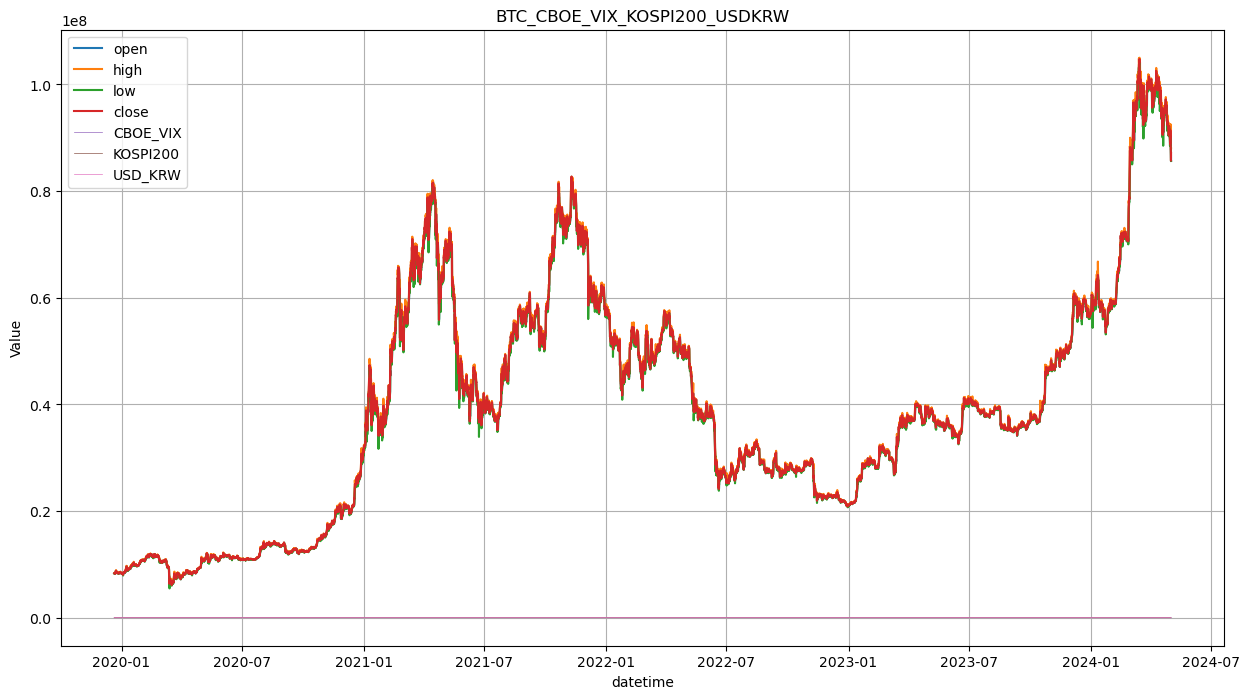

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

df_4 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# datetime 컬럼을 pandas의 datetime 타입으로 변환
df_4['datetime'] = pd.to_datetime(df_4['datetime'])

# datetime을 인덱스로 설정
df_4.set_index('datetime', inplace=True)

plt.figure(figsize=(15,8))

# 각 데이터를 plot에 추가
plt.plot(df_4.index, df_4['open'], label='open')
plt.plot(df_4.index, df_4['high'], label='high')
plt.plot(df_4.index, df_4['low'], label='low')
plt.plot(df_4.index, df_4['close'], label='close')
# plt.plot(ddf_4f.index, df_4['volume'], label='volume', linewidth=0.5)
# plt.plot(df_4.index, df_4['value'], label='value', linewidth=0.5)
plt.plot(df_4.index, df_4['CBOE_VIX'], label='CBOE_VIX', linewidth=0.5)
plt.plot(df_4.index, df_4['KOSPI200'], label='KOSPI200', linewidth=0.5)
plt.plot(df_4.index, df_4['USD_KRW'], label='USD_KRW', linewidth=0.5)

# 범례 위치 조정
plt.legend(loc='best')

# 제목 및 축 이름 설정
plt.title('BTC_CBOE_VIX_KOSPI200_USDKRW')
plt.xlabel('datetime')
plt.ylabel('Value')

# 그리드 표시
plt.grid(True)

# Plot 표시
plt.show()

BTC_CBOE_VIX_KOSPI200_USDKRW indexing plot

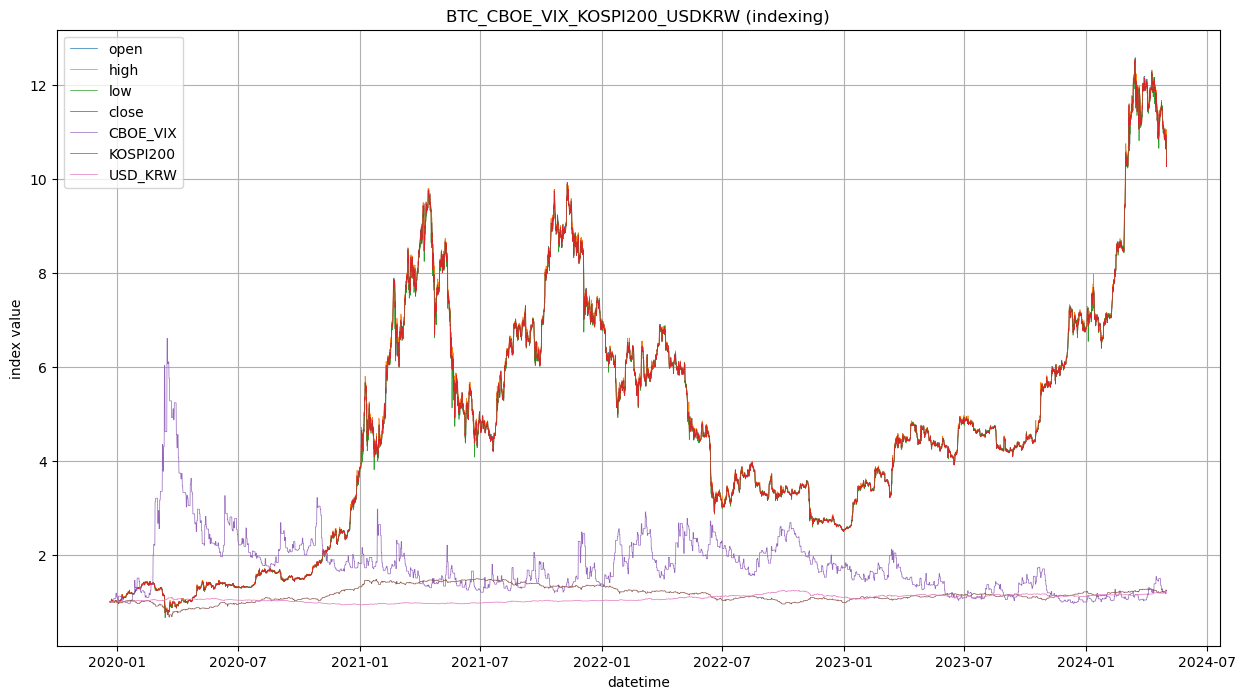

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로드
df_5 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# datetime 컬럼을 pandas의 datetime 타입으로 변환
df_5['datetime'] = pd.to_datetime(df_5['datetime'])

# datetime을 인덱스로 설정
df_5.set_index('datetime', inplace=True)

plt.figure(figsize=(15,8))

# 각 데이터 시리즈를 첫 번째 날짜의 값으로 나누어 인덱싱
df_plot_index = df_5 / df_5.iloc[0]

# 인덱싱된 데이터를 이용하여 plot에 추가
plt.plot(df_plot_index.index, df_plot_index['open'], label='open', linewidth=0.5)
plt.plot(df_plot_index.index, df_plot_index['high'], label='high', linewidth=0.5)
plt.plot(df_plot_index.index, df_plot_index['low'], label='low', linewidth=0.5)
plt.plot(df_plot_index.index, df_plot_index['close'], label='close', linewidth=0.5)
# plt.plot(df_plot_index.index, df_plot_index['volume'], label='volume', linewidth=0.5)
# plt.plot(df_plot_index.index, df_plot_index['value'], label='value', linewidth=0.5)
plt.plot(df_plot_index.index, df_plot_index['CBOE_VIX'], label='CBOE_VIX', linewidth=0.5)
plt.plot(df_plot_index.index, df_plot_index['KOSPI200'], label='KOSPI200', linewidth=0.5)
plt.plot(df_plot_index.index, df_plot_index['USD_KRW'], label='USD_KRW', linewidth=0.5)

# 범례 위치 조정
plt.legend(loc='best')

# 제목 및 축 이름 설정
plt.title('BTC_CBOE_VIX_KOSPI200_USDKRW (indexing)')
plt.xlabel('datetime')
plt.ylabel('index value')

# 그리드 표시
plt.grid(True)

# Plot 표시
plt.show()

Historical Volatility_7days Model

In [40]:
import pandas as pd
import numpy as np

# 데이터 불러오기
df_hv_7 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_hv_7['datetime'] = pd.to_datetime(df_hv_7['datetime'])
df_hv_7.set_index('datetime', inplace=True)

# 로그 수익률 계산
df_hv_7['log_returns'] = np.log(df_hv_7['close'] / df_hv_7['close'].shift(1))
df_hv_7['Next_7_Days_Volatility'] = df_hv_7['log_returns'].iloc[::-1].rolling(window = 42).std().iloc[::-1]

# 7일(42) 이동 평균 역사적 변동성 계산을 위한 빈 리스트 생성 
historical_volatility = []

# 7일(42) 이동 평균 역사적 변동성 계산 
for i in range(len(df_hv_7)):
    if i >= 41:
        # 최근 7일의 로그 수익률 데이터 선택
        log_returns_window = df_hv_7['log_returns'][i-41:i+1]
        # 선택된 데이터의 표준편차 계산
        std_dev = np.std(log_returns_window, ddof=1)
        # 연간화 (sqrt(252)를 곱함) 365*6=2190
        # annualized_vol = std_dev * np.sqrt(2190)
        # historical_volatility.append(annualized_vol)
        historical_volatility.append(std_dev)
    else:
        # 데이터가 7일(42) 미만일 경우 NaN 추가
        historical_volatility.append(np.nan)

# 계산된 역사적 변동성을 DataFrame에 추가
df_hv_7['historical_volatility'] = historical_volatility

# 결과 확인
print(df_hv_7[['close', 'log_returns', 'historical_volatility', 'Next_7_Days_Volatility']])

df_hv_7.to_csv('BTC_CBOE_VIX_KOSPI200_USDKRW_a.csv')

                          close  log_returns  historical_volatility  \
datetime                                                              
2019-12-21 01:00:00   8350000.0          NaN                    NaN   
2019-12-21 05:00:00   8338000.0    -0.001438                    NaN   
2019-12-21 09:00:00   8313000.0    -0.003003                    NaN   
2019-12-21 13:00:00   8279000.0    -0.004098                    NaN   
2019-12-21 17:00:00   8310000.0     0.003737                    NaN   
...                         ...          ...                    ...   
2024-04-30 13:00:00  89801000.0    -0.009873               0.007149   
2024-04-30 17:00:00  87806000.0    -0.022466               0.007842   
2024-04-30 21:00:00  87564000.0    -0.002760               0.007785   
2024-05-01 01:00:00  85684000.0    -0.021704               0.008324   
2024-05-01 05:00:00  87137000.0     0.016815               0.008855   

                     Next_7_Days_Volatility  
datetime                      

Historical_Volatility (7 days) plot

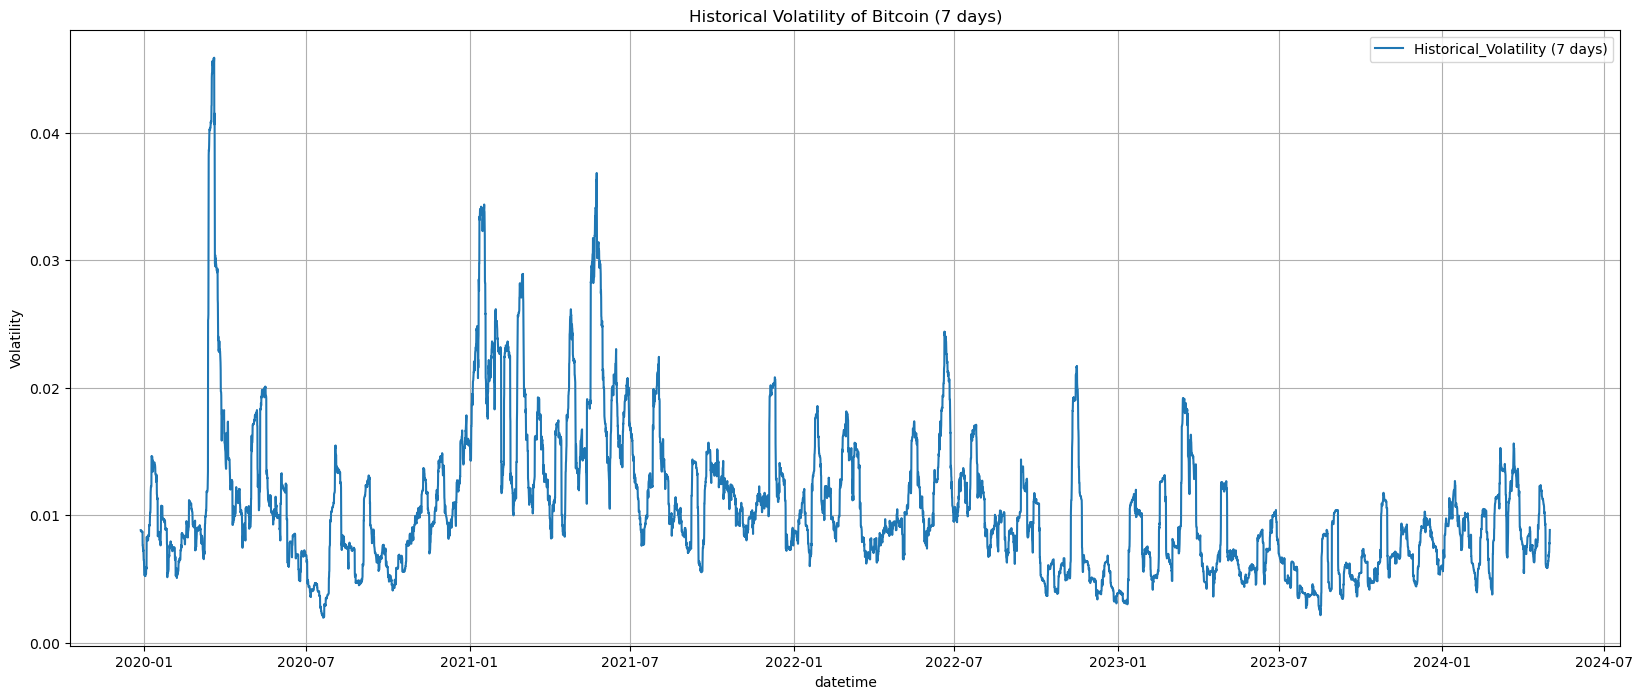

In [41]:
import matplotlib.pyplot as plt

# 역사적 변동성 추이 시각화
plt.figure(figsize=(20, 8))
plt.plot(df_hv_7.index, historical_volatility, label='Historical_Volatility (7 days)') 

plt.title('Historical Volatility of Bitcoin (7 days)') 
plt.xlabel('datetime')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

Historical_Volatility (7 days) & Price(close) plot

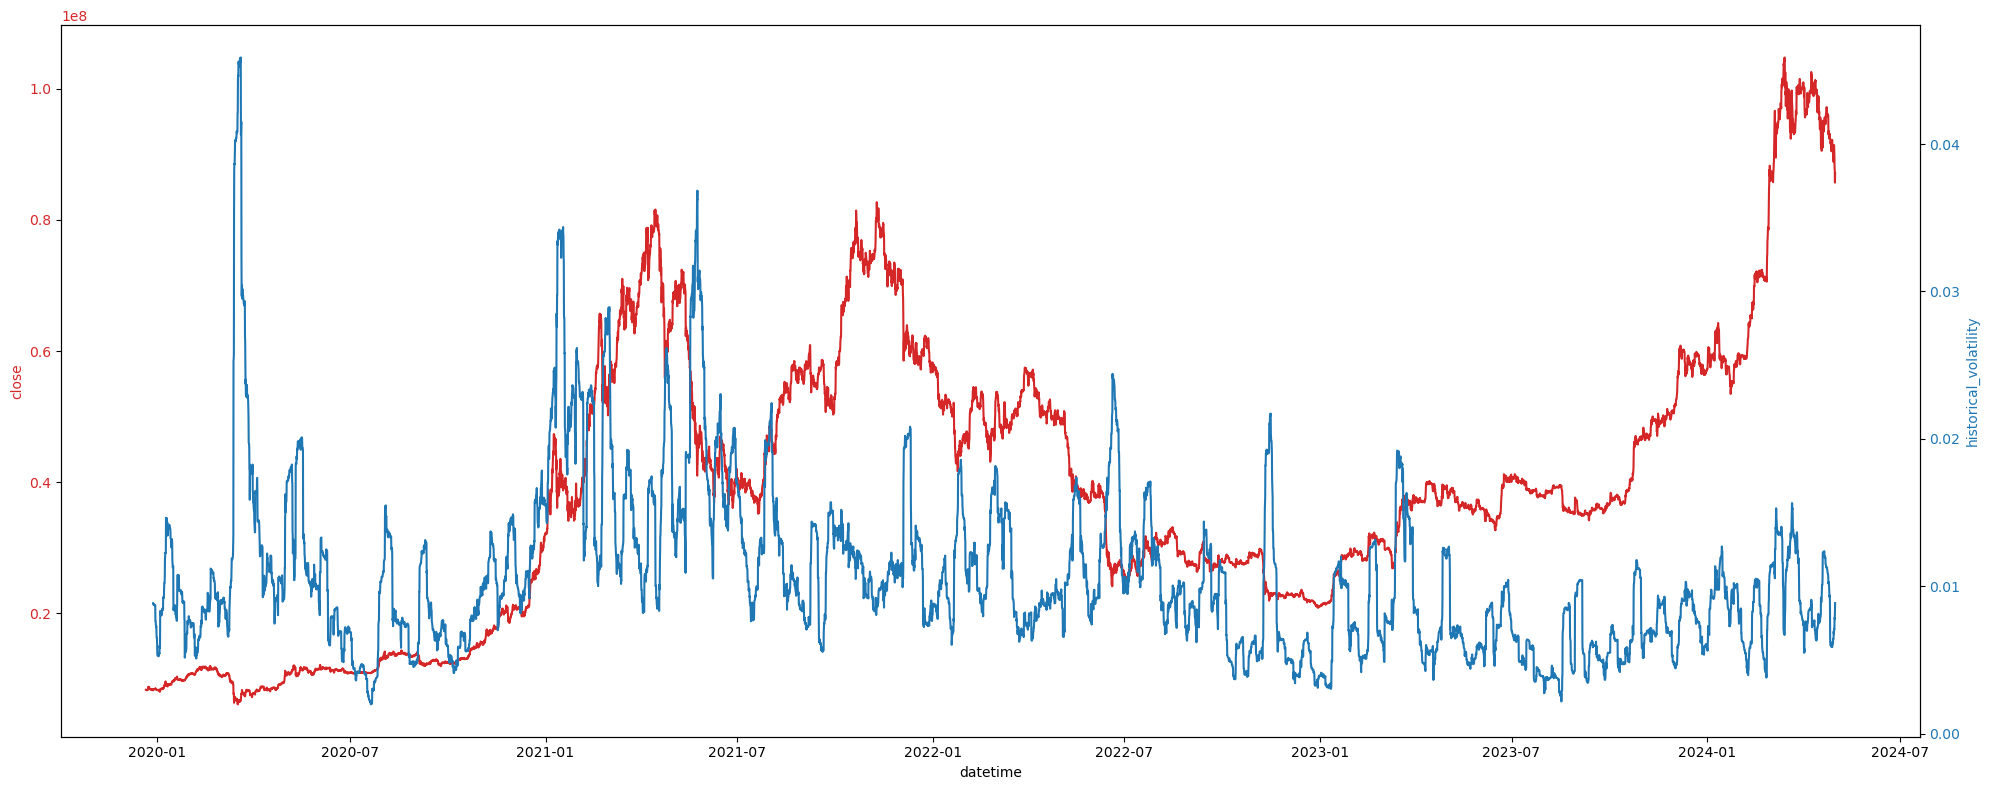

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 그래프 그리기
fig, ax1 = plt.subplots(figsize=(20, 8))

color = 'tab:red'
ax1.set_xlabel('datetime')
ax1.set_ylabel('close', color=color)
ax1.plot(df_hv_7.index, df_hv_7['close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_xlabel('datetime')
ax2.set_ylabel('historical_volatility', color=color)  
ax2.plot(df_hv_7.index, df_hv_7['historical_volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [43]:
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# # 그래프 그리기
# fig, ax1 = plt.subplots(figsize=(20, 8))

# # color = 'tab:red'
# # ax1.set_xlabel('datetime')
# # ax1.set_ylabel('close', color=color)
# # ax1.plot(df_hv_7.index, df_hv_7['close'], color=color)
# # ax1.tick_params(axis='y', labelcolor=color)

# # ax2 = ax1.twinx()  
# color = 'tab:red'
# ax1.set_xlabel('datetime')
# ax1.set_ylabel('historical_volatility', color=color)  
# ax1.plot(df_hv_7.index, df_hv_7['historical_volatility'], color=color)
# ax1.tick_params(axis='y', labelcolor=color)

# ax2 = ax1.twinx()  
# color = 'tab:blue'
# ax2.set_xlabel('datetime')
# ax2.set_ylabel('Next_7_Days_Volatility', color=color)  
# ax2.plot(df_hv_7.index, df_hv_7['Next_7_Days_Volatility'], color=color)
# ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  
# plt.show()

GARCH(1,1) 수익률변동성_7days Model

In [44]:
%pip install --upgrade arch
import numpy as np
import pandas as pd
from arch import arch_model
import datetime as dt
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [45]:
from arch.__future__ import reindexing
import math
import matplotlib.pyplot as plt
%matplotlib inline

# NEW METHOD

In [46]:
df_gar0 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_gar0['datetime'] = pd.to_datetime(df_gar0['datetime'])
df_gar0.set_index('datetime', inplace=True)

df_gar0

open        high         low       close  \
datetime                                                              
2019-12-21 01:00:00   8324000.0   8365000.0   8304000.0   8350000.0   
2019-12-21 05:00:00   8350000.0   8372000.0   8328000.0   8338000.0   
2019-12-21 09:00:00   8342000.0   8342000.0   8301000.0   8313000.0   
2019-12-21 13:00:00   8313000.0   8336000.0   8271000.0   8279000.0   
2019-12-21 17:00:00   8279000.0   8318000.0   8260000.0   8310000.0   
...                         ...         ...         ...         ...   
2024-04-30 13:00:00  90733000.0  90800000.0  89557000.0  89801000.0   
2024-04-30 17:00:00  89801000.0  90000000.0  87289000.0  87806000.0   
2024-04-30 21:00:00  87805000.0  88450000.0  87050000.0  87564000.0   
2024-05-01 01:00:00  87536000.0  87742000.0  85606000.0  85684000.0   
2024-05-01 05:00:00  85684000.0  87980000.0  85627000.0  87137000.0   

                          volume         value  CBOE_VIX  KOSPI200  USD_KRW  
datetime                                                                     
2019-12-21 01:00:00   217.172182  1.810151e+09     12.51    295.31  1158.99  
2019-12-21 05:00:00   140.220142  1.169995e+09     12.51    295.31  1158.99  
2019-12-21 09:00:00   216.799609  1.803141e+09     12.51    295.31  1158.99  
2019-12-21 13:00:00   235.050319  1.951706e+09     12.51    295.31  1158.99  
2019-12-21 17:00:00   194.615774  1.611698e+09     12.51    295.31  1158.99  
...                          ...           ...       ...       ...      ...  
2024-04-30 13:00:00   564.216567  5.082555e+10     15.65    365.13  1385.38  
2024-04-30 17:00:00  2233.925204  1.975182e+11     15.65    365.13  1385.38  
2024-04-30 21:00:00  1440.776009  1.263755e+11     15.65    365.13  1385.38  
2024-05-01 01:00:00  1167.797145  1.012467e+11     15.39    365.13  1377.25  
2024-05-01 05:00:00   985.348435  8.556360e+10     15.39    365.13  1377.25  

[9559 rows x 9 columns]

In [47]:
# 데이터 불러오기
df_gar1 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_gar1['datetime'] = pd.to_datetime(df_gar1['datetime'])
df_gar1.set_index('datetime', inplace=True)

df_gar1['Return'] = np.log(df_gar1['close'] / df_gar1['close'].shift(1))
# NaN 값이 포함된 행 제거
df_gar1.dropna(subset=['Return'], inplace=True)

# 일일/월간/연간 변동성 계산
daily_volatility = df_gar1['Return'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))
monthly_volatility = math.sqrt(180) * daily_volatility
print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))
annual_volatility = math.sqrt(2190) * daily_volatility
print('Annual volatility: ', '{:.2f}%'.format(annual_volatility))

# GARCH(1,1) 모델 적합 및 수익률 변동성 예측
volatility_forecast = []
for i in range(42, len(df_gar1)):
    garch_model = arch_model(df_gar1['Return'].iloc[i-42:i], p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    gm_result = garch_model.fit(disp='off')
    forecast = gm_result.forecast(horizon=42)
    volatility_forecast.append(forecast.variance.values[-1][0]**0.5)

# 기존 DataFrame에 'Return Volatility' 열 추가
df_gar1['Return Volatility'] = pd.Series(volatility_forecast, index=df_gar1.index[42:])

# 수정된 DataFrame을 CSV 파일로 저장
df_gar1.to_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=True)

Daily volatility:  0.01%
Monthly volatility:  0.16%
Annual volatility:  0.57%


c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:7

In [49]:
# 데이터 불러오기
df_gar3 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_gar3['datetime'] = pd.to_datetime(df_gar3['datetime'])
df_gar3.set_index('datetime', inplace=True)

# # 수익률 계산
# df_gar3['Return1'] = np.log(df_gar3['close'] / df_gar3['close'].shift(1))
# df_gar3.dropna(subset=['Return1'], inplace=True)

# # 일일/월간/연간 변동성 계산
# daily_volatility = df_gar3['Return1'].std()
# print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))
# monthly_volatility = math.sqrt(180) * daily_volatility
# print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))
# annual_volatility = math.sqrt(2190) * daily_volatility
# print('Annual volatility: ', '{:.2f}%'.format(annual_volatility))

# volatility_forecast_egarch = []
# for i in range(42, len(df_gar3)):
#     egarch_model = arch_model(df_gar3['Return'].iloc[i-42:i], p=1, o=1, q=1, mean='constant', vol='EGARCH', dist='normal')
#     egm_result = egarch_model.fit(disp='off')
#     forecast = egm_result.forecast(horizon=42)
#     volatility_forecast_egarch.append(forecast.variance.values[-1][0]**0.5)

# # 기존 DataFrame에 'Return Volatility EGARCH' 열 추가
# df_gar3['Return Volatility1'] = pd.Series(volatility_forecast_egarch, index=df_gar3.index[42:])

# EGARCH(1,1) 모델 적합 및 수익률 변동성 예측
volatility_forecast = []
for i in range(42, len(df_gar3)):
    egarch_model = arch_model(df_gar3['Return'].iloc[i-42:i], p=1, o=1, q=1, mean='constant', vol='EGARCH', dist='normal')
    em_result = egarch_model.fit(disp='off')
    forecast = em_result.forecast(horizon=42, method='simulation', simulations=100)
    volatility_forecast.append(forecast.variance.values[-1][0]**0.5)

# 기존 DataFrame에 'Return Volatility' 열 추가
df_gar3['Return Volatility1'] = pd.Series(volatility_forecast, index=df_gar3.index[42:])

# 수정된 DataFrame을 CSV 파일로 저장
df_gar3.to_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=True)

c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration 

# !!!!

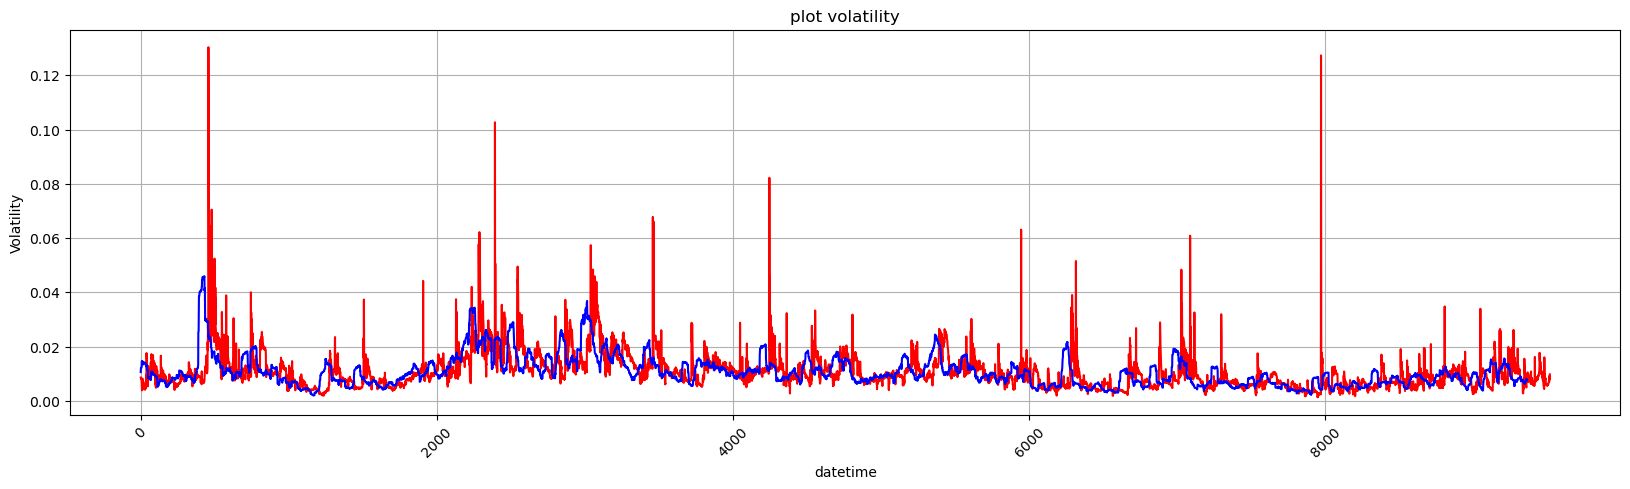

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
df_plot_0 = pd.read_csv('garch_forecast.csv')
df_plot_a = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

plt.figure(figsize=(20, 5)) 
plt.plot(df_plot_0.index, df_plot_0['Return Volatility'], linestyle='-', color='red') 
# plt.plot(df_plot_a.index, df_plot_a['predicted_volatility'], linestyle='-', color='blue') 
plt.plot(df_plot_a.index, df_plot_a['Next_7_Days_Volatility'], linestyle='-', color='blue')
# plt.plot(df_plot_a.index, df_plot_a['garch_vol'], linestyle='-', color='red', label='garch_vol')
# plt.plot(df_plot_a.index, df_plot_a['egarch_vol'], linestyle='-', color='blue', label='egarch_vol')
# plt.plot(df_plot_a.index, df_plot_a['historical_volatility'], linestyle='-', color='green', label='historical_volatility')

plt.title('plot volatility') 
plt.xlabel('datetime') 
plt.ylabel('Volatility') 
plt.xticks(rotation=45) 
plt.grid(True) 

# 그래프를 보여줍니다.
plt.show()

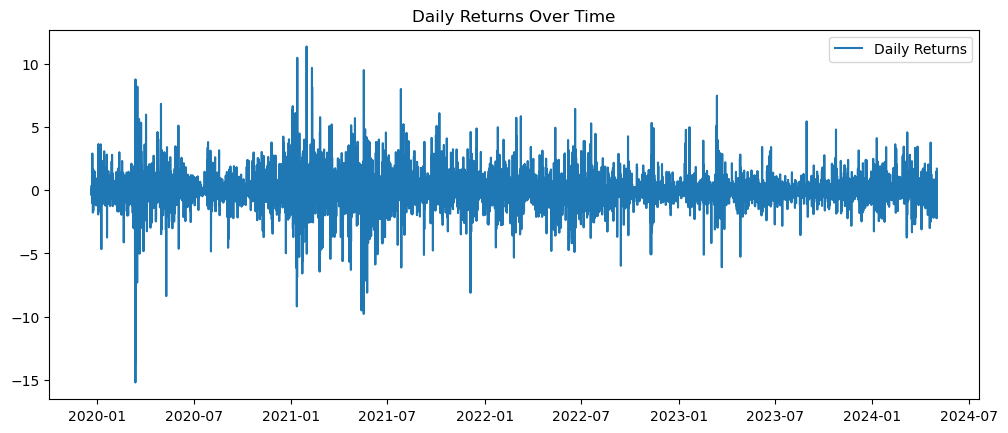

Daily volatility:  1.21%
Monthly volatility:  16.23%
Annual volatility:  56.61%
mu          0.022331
omega       0.015797
alpha[1]    0.073679
beta[1]     0.919766
Name: params, dtype: float64


                          h.1       h.2
datetime                               
2024-05-01 05:00:00  1.495972  1.501963


In [19]:
# # import yfinance as yf
# # from arch import arch_model
# # from arch.__future__ import reindexing
# import math
# # import numpy as np
# # import pandas as pd
# # import matplotlib.pyplot as plt
# # %matplotlib inline

# # ticker= "aapl"
# # stock_data = yf.download(ticker, start="2016–01–04", end="2021–04–30")
# # stock_data['Return'] = 100 * (stock_data['Close'].pct_change())
# # stock_data.dropna(inplace=True)

# # 데이터 불러오기
# df_gar1 = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# df_gar1['datetime'] = pd.to_datetime(df_gar1['datetime'])
# df_gar1.set_index('datetime', inplace=True)
# df_gar1['Return'] = 100 * (df_gar1['close'].pct_change())
# df_gar1.dropna(inplace=True)

# fig = plt.figure()
# fig.set_figwidth(12)
# plt.plot(df_gar1['Return'], label='Daily Returns')
# plt.legend(loc='upper right')
# plt.title('Daily Returns Over Time')
# plt.show()

# daily_volatility = df_gar1['Return'].std()
# print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))
# monthly_volatility = math.sqrt(180) * daily_volatility
# print('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))
# annual_volatility = math.sqrt(2190) * daily_volatility
# print('Annual volatility: ', '{:.2f}%'.format(annual_volatility))

# garch_model = arch_model(df_gar1['Return'], p=1, q=1, mean='constant', vol='GARCH', dist='normal')
# gm_result = garch_model.fit(disp='off')
# print(gm_result.params)

# print('\n')
# gm_forecast = gm_result.forecast(horizon=2)
# print(gm_forecast.variance[-1:])

# # GARCH(1,1) 모델의 미래 42일간 변동성 예측 결과를 CSV 파일로 저장
# gm_forecast_df = pd.DataFrame(gm_forecast.variance[-1:], columns=['Volatility'])
# gm_forecast_df.to_csv('garch_forecast.csv')

GARCH(1,1) model_ windowsize(42)_ all dataset

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from arch import arch_model

# 데이터 로딩
df_garch = pd.read_csv('BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_garch['datetime'] = pd.to_datetime(df_garch['datetime'])
df_garch.set_index('datetime', inplace=True)

# 로그 수익률 계산 (첫 번째 NaN 값을 0으로 대체)
# df_garch['log_returns'] = np.log(df_garch['close'] / df_garch['close'].shift(1)).fillna(0)

df_garch['log_returns_ret'] = np.log(df_garch['close'] / df_garch['close'].shift(1))

# NaN 값이 포함된 행 제거
df_garch.dropna(subset=['log_returns_ret'], inplace=True)

# 데이터 분할
train_size = int(len(df_garch) * 0.6)
validation_size = int(len(df_garch) * 0.2)
test_size = len(df_garch) - train_size - validation_size

train_df = df_garch[:train_size]
validation_df = df_garch[train_size:train_size+validation_size]
test_df = df_garch[train_size+validation_size:]

window_size = 42
predictions = []
alphas = []
betas = []

# 모델 훈련 및 파라미터 추출
for end in range(window_size, len(df_garch)):
    train_subset = df_garch['log_returns'][end-window_size:end]
    model = arch_model(train_subset, p=1, q=1, mean='constant', vol='GARCH', dist='normal')
    model_fit = model.fit(disp='off')
    
    alpha = model_fit.params['alpha[1]']
    beta = model_fit.params['beta[1]']
    
    pred = model_fit.forecast(horizon=1)
    predictions.append(pred.variance.values[-1][0])
    alphas.append(alpha)
    betas.append(beta)

# 예측 결과를 데이터 프레임에 매칭
df_garch['predicted_volatility'] = np.nan

# 예측된 변동성 값을 해당 위치에 매칭합니다.
for i, pred in enumerate(predictions):
    df_garch.iloc[i + window_size, df_garch.columns.get_loc('predicted_volatility')] = pred

# 연율화
# df_garch['predicted_volatility'] = df_garch['predicted_volatility'] * np.sqrt(6 * 365)

# 변경된 데이터 프레임을 새로운 CSV 파일로 저장
df_garch.to_csv('GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Anaconda\Lib\site-packages\arch\univariat

In [42]:
# 파라미터 값 출력
for i in range(len(predictions)):
    print(f"Prediction {i+1}: Alpha={alphas[i]}, Beta={betas[i]}")

Prediction 1: Alpha=0.09106888531256632, Beta=0.5705290859145432
Prediction 2: Alpha=0.08365551829483152, Beta=0.5226767045071556
Prediction 3: Alpha=0.13050977181360773, Beta=2.874335412645984e-14
Prediction 4: Alpha=0.12943882283055838, Beta=2.732357083918616e-16
Prediction 5: Alpha=0.1317497605164839, Beta=5.3005377864678863e-17
Prediction 6: Alpha=0.009999984939255944, Beta=0.8899986009859532
Prediction 7: Alpha=0.04999984478033306, Beta=0.8499973402116567
Prediction 8: Alpha=0.09999935458451353, Beta=0.87999429879378
Prediction 9: Alpha=0.199999808000002, Beta=0.7799992222000078
Prediction 10: Alpha=0.19999936364290818, Beta=0.7799975025132488
Prediction 11: Alpha=0.19999960536668687, Beta=0.7799984580110176
Prediction 12: Alpha=0.19999961173909003, Beta=0.7799984483646332
Prediction 13: Alpha=0.19999946798145304, Beta=0.6999981378992015
Prediction 14: Alpha=0.199999841481473, Beta=0.6999994451916167
Prediction 15: Alpha=0.20000411307926383, Beta=0.49999742932574104
Prediction 16:

In [43]:
import pandas as pd

# 기존에 생성된 CSV 파일 로드
df_garch_1 = pd.read_csv('GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index_col='datetime')
# df_garch_1['datetime'] = pd.to_datetime(df_garch_1.index)

# 알파와 베타 값을 저장할 새로운 열 추가 (초기값은 NaN으로 설정)
df_garch_1['alpha'] = np.nan
df_garch_1['beta'] = np.nan

# 예측 시작 인덱스 설정 (위의 코드에서 예측이 시작되는 행 번호)
start_index = window_size

# 알파와 베타 값 매칭 및 저장
for i, (alpha, beta) in enumerate(zip(alphas, betas)):
    # 예측 시작 인덱스부터 알파, 베타 값을 적용
    df_garch_1.iloc[start_index + i, df_garch_1.columns.get_loc('alpha')] = alpha
    df_garch_1.iloc[start_index + i, df_garch_1.columns.get_loc('beta')] = beta

# 'datetime' 열을 인덱스에서 제거하고, 첫 번째 열로 다시 설정
df_garch_1.reset_index(inplace=True)
df_garch_1 = df_garch_1[['datetime'] + [col for col in df_garch_1.columns if col != 'datetime']]

# 나머지 컬럼들과 함께 변경된 데이터프레임을 CSV 파일로 저장
df_garch_1.to_csv('para_GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

# 확인을 위해 몇 가지 행 출력
print(df_garch_1.head())

              datetime       open       high        low      close  \
0  2019-12-21 05:00:00  8350000.0  8372000.0  8328000.0  8338000.0   
1  2019-12-21 09:00:00  8342000.0  8342000.0  8301000.0  8313000.0   
2  2019-12-21 13:00:00  8313000.0  8336000.0  8271000.0  8279000.0   
3  2019-12-21 17:00:00  8279000.0  8318000.0  8260000.0  8310000.0   
4  2019-12-21 21:00:00  8312000.0  8321000.0  8267000.0  8300000.0   

       volume         value  CBOE_VIX  KOSPI200  USD_KRW  log_returns  \
0  140.220142  1.169995e+09     12.51    295.31  1158.99    -0.001438   
1  216.799609  1.803141e+09     12.51    295.31  1158.99    -0.003003   
2  235.050319  1.951706e+09     12.51    295.31  1158.99    -0.004098   
3  194.615774  1.611698e+09     12.51    295.31  1158.99     0.003737   
4  161.378247  1.338886e+09     12.51    295.31  1158.99    -0.001204   

   Next_7_Days_Volatility  historical_volatility  log_returns_ret  \
0                0.008753                    NaN        -0.001438   
1 

In [44]:
# df_garch_1 = pd.read_csv('para_GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

log_ret_1 = np.log(df_garch_1['KOSPI200'] / df_garch_1['KOSPI200'].shift(1))
log_ret_2 = np.log(df_garch_1['USD_KRW'] / df_garch_1['USD_KRW'].shift(1))
log_ret_3 = np.log(df_garch_1['CBOE_VIX'] / df_garch_1['CBOE_VIX'].shift(1))

#변동성 계산해서 추가
df_garch_1['KOSPI200_vol'] = log_ret_1.rolling(window=42).std()
df_garch_1['USD_KRW_vol'] = log_ret_2.rolling(window=42).std()
df_garch_1['CBOE_VIX_vol'] = log_ret_3.rolling(window=42).std()

# 나머지 컬럼들과 함께 변경된 데이터프레임을 CSV 파일로 저장
df_garch_1.to_csv('para_GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

Pyflux result_(1)

In [45]:
import pandas as pd

df_py = pd.read_csv('pyflux.csv')

# 연율화 계수 계산
# df_py['garch_vol_pyflux'] = df_py['garch_vol_pyflux'] * np.sqrt(6 * 365)

# 결과를 새 CSV 파일로 저장
df_py.to_csv('pyflux_1.csv', index=False)

In [46]:
import pandas as pd

# 새로운 CSV 파일에서 'predicted_volatility' 열 로드
df_py_3 = pd.read_csv('pyflux_1.csv', usecols=['index', 'garch_vol_pyflux'])
df_py_3['index'] = pd.to_datetime(df_py_3['index'])

# 기존 CSV 파일 로드
df_py_4 = pd.read_csv('para_GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_py_4['datetime'] = pd.to_datetime(df_py_4['datetime'])

# datetime을 인덱스로 설정하여 두 데이터프레임 병합
df_py_4 = df_py_4.set_index('datetime')
df_py_3 = df_py_3.set_index('index')
df_py_5 = df_py_4.join(df_py_3, how='left')

# 인덱스를 다시 컬럼으로 변환
df_py_5.reset_index(inplace=True)

# 수정된 데이터프레임을 CSV 파일로 저장
df_py_5.to_csv('para_py_GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [47]:
df_py_6 = pd.read_csv('para_py_GARCH_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# # 데이터 분할 인덱스 설정
# train_end = df_py_6.index.get_loc('2022-12-31 21:00:00')
# valid_end = df_py_6.index.get_loc('2023-12-31 21:00:00')
# # 훈련 데이터셋
# log_ret_train = log_ret[1:train_end+1]
# # 검증 데이터셋
# log_ret_valid = log_ret[train_end+1:valid_end+1]
# # 테스트 데이터셋
# log_ret_test = log_ret[valid_end+1:]

log_ret = df_py_6["log_returns"]

# 데이터 길이 계산
total_length = len(df_py_6)

# 데이터 분할 인덱스 설정
train_end = int(total_length * 0.6)
valid_end = int(total_length * 0.8)

# 훈련 데이터셋
log_ret_train = log_ret[:train_end]

# 검증 데이터셋 
log_ret_valid = log_ret[train_end:valid_end]

# 테스트 데이터셋
log_ret_test = log_ret[valid_end:]

# GARCH류 모델 적합 및 변동성 추출

def fit_garch_and_get_total_volatility(vol, p, o, q):
    # 훈련 데이터에 대한 모델 적합
    garch_train = arch_model(log_ret_train, mean='zero', vol=vol, p=p, o=o, q=q).fit(disp='off')
    train_volatility = garch_train.conditional_volatility

    # 검증 데이터에 대한 모델 적합
    garch_valid = arch_model(log_ret_valid, mean='zero', vol=vol, p=p, o=o, q=q).fit(disp='off', last_obs=train_df-1)
    valid_volatility = garch_valid.conditional_volatility

    # 테스트 데이터에 대한 모델 적합
    garch_test = arch_model(log_ret_test, mean='zero', vol=vol, p=p, o=o, q=q).fit(disp='off', last_obs=validation_df-1)
    test_volatility = garch_test.conditional_volatility

    # 최종 데이터 결합
    total_volatility = pd.concat([train_volatility, valid_volatility, test_volatility])
    
    return total_volatility

total_volatility_garch = fit_garch_and_get_total_volatility(vol= 'GARCH', p=1, o=0, q=1)
total_volatility_egarch = fit_garch_and_get_total_volatility(vol= 'EGARCH', p=1, o=1, q=1)

# 연율화
# total_volatility_garch = total_volatility_garch * np.sqrt(6 * 365)
# total_volatility_egarch = total_volatility_egarch * np.sqrt(6 * 365)

# 시리즈화
total_volatility_garch = pd.Series(total_volatility_garch, name ='garch_vol')
total_volatility_egarch = pd.Series(total_volatility_egarch, name ='egarch_vol')

# 인덱스 기준 원데이터에 합침
df_py_6 = df_py_6.join(total_volatility_garch)
df_py_6 = df_py_6.join(total_volatility_egarch)

# 수정된 데이터프레임을 CSV 파일로 저장
df_py_6.to_csv('para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [48]:
df_py_7 = pd.read_csv('para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

df_py_8 = df_py_7.drop('log_returns_ret', axis=1)
# 처음 6개 행 제거
df_py_8 = df_py_8[65:]
# 마지막 10개 행 제거
df_py_8 = df_py_8[:-132]

# 수정된 데이터프레임을 CSV 파일로 저장
df_py_8.to_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

parameter 없는 version

In [49]:
df_py_9 = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
df_py_9 = df_py_9.drop('alpha', axis=1)
df_py_9 = df_py_9.drop('beta', axis=1)

# 수정된 데이터프레임을 CSV 파일로 저장
df_py_9.to_csv('real_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

Plot

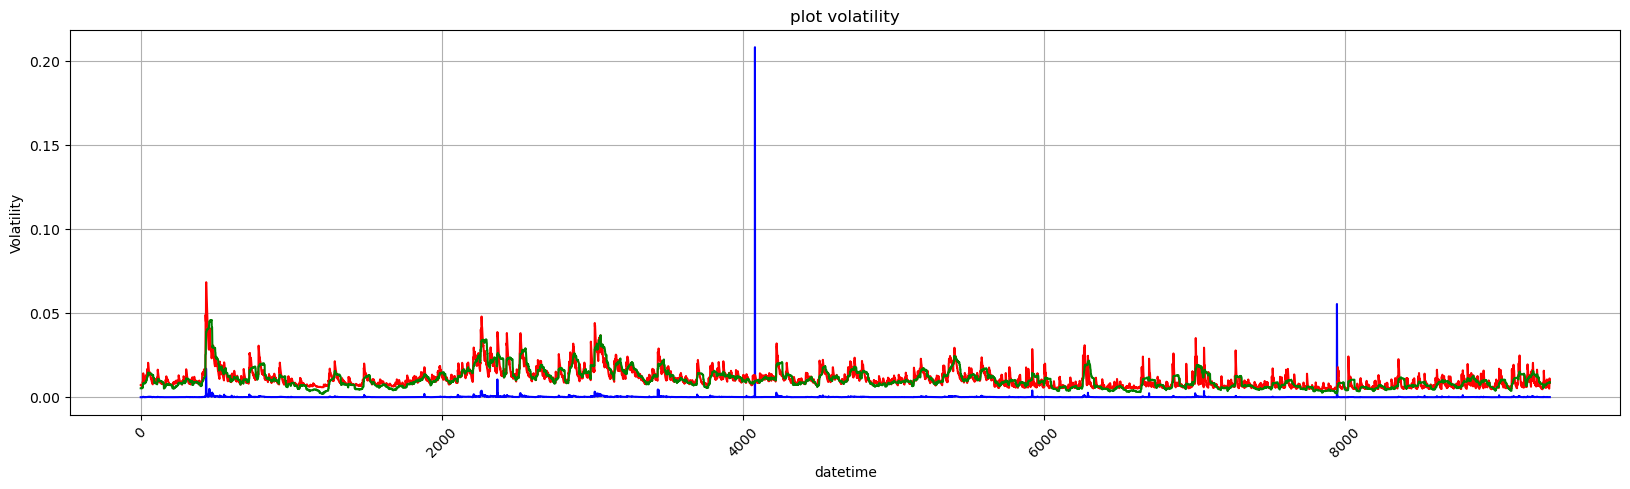

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df_plot_2 = pd.read_csv('real_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

plt.figure(figsize=(20, 5)) 
plt.plot(df_plot_2.index, df_plot_2['predicted_volatility'], linestyle='-', color='blue') 
plt.plot(df_plot_2.index, df_plot_2['garch_vol'], linestyle='-', color='red', label='garch_vol')
# plt.plot(df_plot_2.index, df_plot_2['egarch_vol'], linestyle='-', color='blue', label='egarch_vol')
plt.plot(df_plot_2.index, df_plot_2['historical_volatility'], linestyle='-', color='green', label='historical_volatility')

plt.title('plot volatility') 
plt.xlabel('datetime') 
plt.ylabel('Volatility') 
plt.xticks(rotation=45) 
plt.grid(True) 

# 그래프를 보여줍니다.
plt.show()

In [27]:
import pandas as pd

df_10 = pd.read_csv('real_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 열 이름 리스트 만들기
new_column_order = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'value',
                    'CBOE_VIX', 'KOSPI200', 'USD_KRW', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol',
                    'log_returns', 'historical_volatility', 'predicted_volatility',
                    'garch_vol', 'egarch_vol', 'garch_vol_pyflux', 'Next_7_Days_Volatility']

# 열 순서 변경하기
df_10 = df_10[new_column_order]
df_10.to_csv('real_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [28]:
import pandas as pd

df_11 = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 열 이름 리스트 만들기
new_column_order = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'value',
                    'CBOE_VIX', 'KOSPI200', 'USD_KRW', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol',
                    'log_returns', 'historical_volatility', 'predicted_volatility',
                    'garch_vol', 'egarch_vol', 'garch_vol_pyflux', 'alpha', 'beta', 'Next_7_Days_Volatility']

# 열 순서 변경하기
df_11 = df_11[new_column_order]
df_11.to_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

MinMaxScaler_정규화

In [29]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# df_sc = pd.read_csv('real_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# scaler = MinMaxScaler()

# df_sc['open'] = scaler.fit_transform(df_sc['open'].values.reshape(-1, 1))
# df_sc['high'] = scaler.fit_transform(df_sc['high'].values.reshape(-1, 1))
# df_sc['low'] = scaler.fit_transform(df_sc['low'].values.reshape(-1, 1))
# df_sc['close'] = scaler.fit_transform(df_sc['close'].values.reshape(-1, 1))
# df_sc['volume'] = scaler.fit_transform(df_sc['volume'].values.reshape(-1, 1))
# df_sc['value'] = scaler.fit_transform(df_sc['value'].values.reshape(-1, 1))

# df_sc.to_csv('final_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [30]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# df_sc_1 = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# scaler = MinMaxScaler()

# df_sc_1['open'] = scaler.fit_transform(df_sc_1['open'].values.reshape(-1, 1))
# df_sc_1['high'] = scaler.fit_transform(df_sc_1['high'].values.reshape(-1, 1))
# df_sc_1['low'] = scaler.fit_transform(df_sc_1['low'].values.reshape(-1, 1))
# df_sc_1['close'] = scaler.fit_transform(df_sc_1['close'].values.reshape(-1, 1))
# df_sc_1['volume'] = scaler.fit_transform(df_sc_1['volume'].values.reshape(-1, 1))
# df_sc_1['value'] = scaler.fit_transform(df_sc_1['value'].values.reshape(-1, 1))

# df_sc_1.to_csv('final_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [31]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# df_sc_2 = pd.read_csv('final_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# scaler = MinMaxScaler()

# df_sc_2['predicted_volatility'] = scaler.fit_transform(df_sc_2['predicted_volatility'].values.reshape(-1, 1))
# df_sc_2['garch_vol'] = scaler.fit_transform(df_sc_2['garch_vol'].values.reshape(-1, 1))

# df_sc_2.to_csv('forplot_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

# import pandas as pd
# import matplotlib.pyplot as plt

# df_sc_2 = pd.read_csv('forplot_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# plt.figure(figsize=(20, 5)) 
# plt.plot(df_sc_2.index, df_sc_2['predicted_volatility'], linestyle='-', color='blue') 
# plt.plot(df_sc_2.index, df_sc_2['garch_vol'], linestyle='-', color='red', label='garch_vol')
# # # plt.plot(df_sc_2.index, df_sc_2['egarch_vol'], linestyle='-', color='blue', label='egarch_vol')
# # plt.plot(df_sc_2.index, df_sc_2['historical_volatility'], linestyle='-', color='green', label='historical_volatility')

# plt.title('plot volatility') 
# plt.xlabel('datetime') 
# plt.ylabel('Volatility') 
# plt.xticks(rotation=45) 
# plt.grid(True) 

# # 그래프를 보여줍니다.
# plt.show()

In [32]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# df_sc_3 = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# scaler = MinMaxScaler()

# df_sc_3['open'] = scaler.fit_transform(df_sc_3['open'].values.reshape(-1, 1))
# df_sc_3['high'] = scaler.fit_transform(df_sc_3['high'].values.reshape(-1, 1))
# df_sc_3['low'] = scaler.fit_transform(df_sc_3['low'].values.reshape(-1, 1))
# df_sc_3['close'] = scaler.fit_transform(df_sc_3['close'].values.reshape(-1, 1))
# df_sc_3['volume'] = scaler.fit_transform(df_sc_3['volume'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['value'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['CBOE_VIX'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['KOSPI200'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['USD_KRW'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['KOSPI200_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['USD_KRW_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['log_returns'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['historical_volatility'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['predicted_volatility'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['garch_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['egarch_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['garch_vol_pyflux'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['egarch_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['Next_7_Days_Volatility'].values.reshape(-1, 1))

# df_sc_3.to_csv('final2_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [33]:
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler

# df_sc_3 = pd.read_csv('real_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# scaler = MinMaxScaler()

# df_sc_3['open'] = scaler.fit_transform(df_sc_3['open'].values.reshape(-1, 1))
# df_sc_3['high'] = scaler.fit_transform(df_sc_3['high'].values.reshape(-1, 1))
# df_sc_3['low'] = scaler.fit_transform(df_sc_3['low'].values.reshape(-1, 1))
# df_sc_3['close'] = scaler.fit_transform(df_sc_3['close'].values.reshape(-1, 1))
# df_sc_3['volume'] = scaler.fit_transform(df_sc_3['volume'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['value'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['CBOE_VIX'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['KOSPI200'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['USD_KRW'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['KOSPI200_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['USD_KRW_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['log_returns'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['historical_volatility'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['predicted_volatility'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['garch_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['egarch_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['garch_vol_pyflux'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['egarch_vol'].values.reshape(-1, 1))
# df_sc_3['value'] = scaler.fit_transform(df_sc_3['Next_7_Days_Volatility'].values.reshape(-1, 1))

# df_sc_3.to_csv('final2_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [34]:
df_12 = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 특정 열 삭제
df_12 = df_12.drop('open', axis=1)
df_12 = df_12.drop('high', axis=1)
df_12 = df_12.drop('low', axis=1)
df_12 = df_12.drop('volume', axis=1)
df_12 = df_12.drop('value', axis=1)

# 수정된 데이터프레임을 CSV 파일로 저장
df_12.to_csv('2real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [35]:
df_13 = pd.read_csv('2real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

def difference(dataset):
    diff = []
    for i in range(len(dataset)):
        value = ((dataset[i] - dataset[0]) / dataset[0]) + 1
        diff.append(value)
    return np.array(diff)

# 비트코인 close 데이터 추출
close_prices = df_13['close']

# 차이 계산
diff_13 = difference(close_prices)

# 기존 DataFrame에 새로운 close 데이터 추가
df_13['close'] = diff_13

# 기존 CSV 파일에 업데이트
df_13.to_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

In [36]:
df_14 = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# 특정 열 삭제
df_14 = df_14.drop('close', axis=1)
df_14 = df_14.drop('CBOE_VIX', axis=1)
df_14 = df_14.drop('KOSPI200', axis=1)
df_14 = df_14.drop('USD_KRW', axis=1)
df_14 = df_14.drop('CBOE_VIX_vol', axis=1)
df_14 = df_14.drop('KOSPI200_vol', axis=1)
df_14 = df_14.drop('USD_KRW_vol', axis=1)
df_14 = df_14.drop('alpha', axis=1)
df_14 = df_14.drop('beta', axis=1)

df_14.to_csv('lstm_real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv', index=False)

Pearson Correlation Matrix

In [37]:
import seaborn as sns

In [38]:
def build_pearson_correlation_matrix_of_dataframe(size_x,size_y,dataframe,correlation_target,correlation_minimum_criteria):

    # Using Pearson Correlation

    plt.figure(figsize=(size_x,size_y))
    cor = dataframe.corr()
    sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
    # plt.savefig('Images/pearson_correlation_matrix.png', bbox_inches='tight')
    plt.show()

    # Correlation with output variable

    target = abs(cor[correlation_target])

    #Selecting and printing highly correlated features

    relevant_features = target[target>correlation_minimum_criteria]
    print(relevant_features)

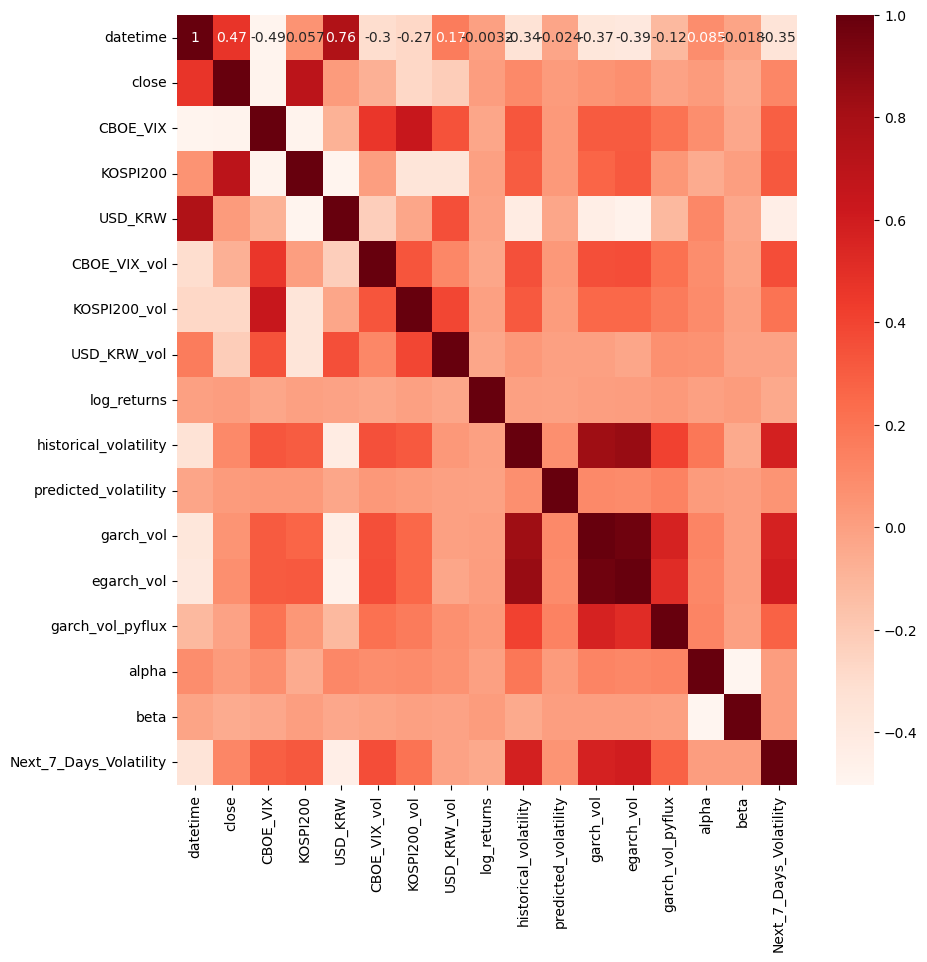

datetime                  0.345405
CBOE_VIX                  0.290005
KOSPI200                  0.322998
USD_KRW                   0.438974
CBOE_VIX_vol              0.361673
KOSPI200_vol              0.204359
historical_volatility     0.580945
garch_vol                 0.575514
egarch_vol                0.598298
garch_vol_pyflux          0.279348
Next_7_Days_Volatility    1.000000
Name: Next_7_Days_Volatility, dtype: float64


In [39]:
df_13['datetime'] = pd.to_datetime(df_13['datetime'])

build_pearson_correlation_matrix_of_dataframe(10, 10, df_13, "Next_7_Days_Volatility", 0.2)

pyflux 다운 X

In [40]:
# # pyflux 이용
# import pyflux as pf
# import pyupbit
# import pandas as pd
# import numpy as np
# from arch import arch_model 

# from pandas_datareader import DataReader
# from datetime import datetime
# import matplotlib.pyplot as plt
# %matplotlib inline

# df_mypy = pd.read_csv('3_para_garch_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# #역사적 변동성 구하기
# log_ret = np.log(df_mypy['close'] / df_mypy['close'].shift(1))
# df_mypy['log_ret'] = np.log(df_mypy['close'] / df_mypy['close'].shift(1))

# # 로그 수익률의 제곱에 대한 이동 평균을 사용하여 변동성 계산
# # 데이터 분할 인덱스 설정
# train_end = df_mypy.index.get_loc('2022-12-31 21:00:00')
# valid_end = df_mypy.index.get_loc('2023-12-31 21:00:00')

# #data_close 나누기
# #data_close = data_close[:train_end+1]

# window_size = 42  # 과거 42개의 데이터 포인트를 사용하여 모델을 훈련
# predictions = []

# # 주간 변동성 예측을 위한 모델 훈련 및 예측
# for end in range(window_size, len(df_mypy)+1):
#     train_subset = df_mypy.iloc[end-window_size:end][['log_ret']]  # 마지막 window_size 개수 만큼 데이터를 선택
#     GARCH_model = pf.GARCH(train_subset, target='log_ret', p=1, q=1)
#     model_fit = GARCH_model.fit()
#     pred = GARCH_model.predict(h=1)  # 다음 시점을 예측
    
#     # 예측된 결과의 구조를 확인한 후 올바른 컬럼 이름으로 접근
#     # 예시: predictions.append(pred['예측된_변동성_컬럼명'].values[-1])
    
#     predictions.append(pred.values[-1][0])

# #시리즈화
# total_volatility_garch = pd.Series(predictions, name ='garch_vol_pyflux')
# total_volatility_garch = total_volatility_garch * np.sqrt(6 * 365)

# #인덱스에 매핑하기 위해서 data_close index를 숫자 인덱스로 변환
# df_mypy.reset_index(inplace=True)

# # total_volatility_garch 시리즈의 길이를 기반으로 인덱스 범위 생성
# start_index = 42
# end_index = start_index + len(total_volatility_garch)  # 시작 인덱스 + 시리즈의 길이

# # 새로운 인덱스 설정
# total_volatility_garch.index = range(start_index, end_index)

# #인덱스 기준 원데이터에 합침
# df_mypy1 = df_mypy.join(total_volatility_garch)

# df_mypy1.to_csv("my_pyflux.csv", encoding='UTF-8')

LSTM MODEL _ before

In [41]:
# import pandas as pd
# import numpy as np

# # CSV 파일 읽기
# df_a = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
# print(df_a.shape)

In [42]:
# class ForecastLSTM:
#     def __init__(self, random_seed: int = 1234):
#         self.random_seed = random_seed

# def reshape_dataset(self, df: pd.DataFrame) -> np.array:
#     # y 컬럼을 데이터프레임의 맨 마지막 위치로 이동
#     if "Next_7_Days_Volatility" in df.columns:
#         df = df.drop(columns=["Next_7_Days_Volatility"]).assign(y=df["Next_7_Days_Volatility"])
#     else:
#         raise KeyError("Not found target column 'Next_7_Days_Volatility' in dataset.")
    
#     # shape 변경
#     dataset = df.values.reshape(df.shape)
#     return dataset

# ForecastLSTM.reshape_dataset = reshape_dataset

In [43]:
# def split_sequences(
#     self, dataset: np.array, seq_len: int, steps: int, single_output: bool
#     ) -> tuple:

#     # feature와 y 각각 sequential dataset을 반환할 리스트 생성
#     X, y = list(), list()
#     # sequence length와 step에 따라 sequential dataset 생성
#     for i in range(len(dataset) - seq_len - steps + 1):
#         seq_x = dataset[i:i+seq_len, :-1]
#         if single_output:
#             seq_y = dataset[i+seq_len:i+seq_len+1, -1]
#         else:
#             seq_y = dataset[i+seq_len:i+seq_len+steps, -1]
#         X.append(seq_x)
#         y.append(seq_y)
#     return np.array(X), np.array(y)

# ForecastLSTM.split_sequences = split_sequences

# # 데이터셋 분리
# model = ForecastLSTM()
# dataset = model.reshape_dataset(df_a)
# X, y = model.split_sequences(dataset, seq_len=42, steps=1, single_output=True)

# # 결과 확인
# print("X shape:", X.shape)
# print("y shape:", y.shape)

# # 첫 번째 sequence 출력
# print("First sequence X:\n", X[0])
# print("First sequence y:\n", y[0])

In [44]:
# import pandas as pd
# import numpy as np

# # CSV 파일 읽기
# df_b = pd.read_csv('real_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')

# # 데이터셋 생성 함수
# def create_dataset(df_b, start_idx=1, seq_length=7, step=1):
#     X = []
#     y = []
#     for i in range(start_idx, len(df_b) - seq_length):
#         X_sample = df_b.iloc[i:i+seq_length, :]
#         y_sample = df_b.iloc[i+seq_length, :]
#         X.append(X_sample)
#         y.append(y_sample)
#     return np.array(X), np.array(y)

# # 데이터셋 생성
# data1_X, data1_y = create_dataset(df_b, start_idx=1, seq_length=7, step=1)
# data2_X, data2_y = create_dataset(df_b, start_idx=2, seq_length=7, step=1)
# data3_X, data3_y = create_dataset(df_b, start_idx=3, seq_length=7, step=1)
# # 추가적인 데이터셋 생성 반복

# # 데이터셋 확인
# print(data1_X.shape, data1_y.shape)
# print(data2_X.shape, data2_y.shape)
# print(data3_X.shape, data3_y.shape)

X_train: (6534, 42, 6) Y_train: (6534, 1)
X_test: (554, 42, 6) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - loss: 3.7159e-04 - root_mean_squared_error: 0.0188 - val_loss: 6.3128e-05 - val_root_mean_squared_error: 0.0079
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 3.2734e-04 - root_mean_squared_error: 0.0175 - val_loss: 9.7999e-05 - val_root_mean_squared_error: 0.0099
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - loss: 1.5592e-04 - root_mean_squared_error: 0.0124 - val_loss: 3.4244e-05 - val_root_mean_squared_error: 0.0059
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.4894e-04 - root_mean_squared_error: 0.0122 - val_loss: 6.0248e-05 - val_root_mean_squared_error: 0.0078
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.5128e-04 - root_mean_squared_error: 0.0153 - val_loss: 2.8855e-05 - val_root_mean_squared_error: 0.0054
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 6.2856e-05 - root_mean_squared_error

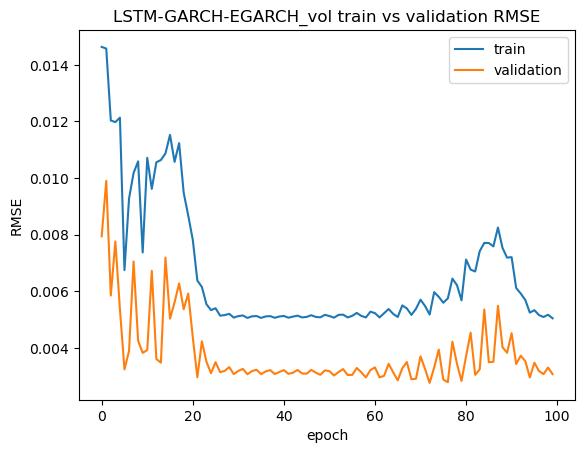

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step
/nRMSE:/n
0.003028297224335928
/nHMAE: 0.86
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [45]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'egarch_vol', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=512,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH-EGARCH_pred_actual_values_D.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 7) Y_train: (6534, 1)
X_test: (554, 42, 7) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 575ms/step - loss: 1.7001e-04 - root_mean_squared_error: 0.0129 - val_loss: 1.2149e-05 - val_root_mean_squared_error: 0.0035
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 571ms/step - loss: 1.6489e-04 - root_mean_squared_error: 0.0127 - val_loss: 4.4433e-05 - val_root_mean_squared_error: 0.0067
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 553ms/step - loss: 1.1167e-04 - root_mean_squared_error: 0.0105 - val_loss: 1.2105e-04 - val_root_mean_squared_error: 0.0110
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 549ms/step - loss: 9.4819e-05 - root_mean_squared_error: 0.0096 - val_loss: 5.1171e-05 - val_root_mean_squared_error: 0.0072
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 564ms/step - loss: 9.3589e-05 - root_mean_squared_error: 0.0095 - val_loss: 5.5132e-05 - val_root_mean_squared_error: 0.0074
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 573ms/step - loss: 9.6547e-05 - root_

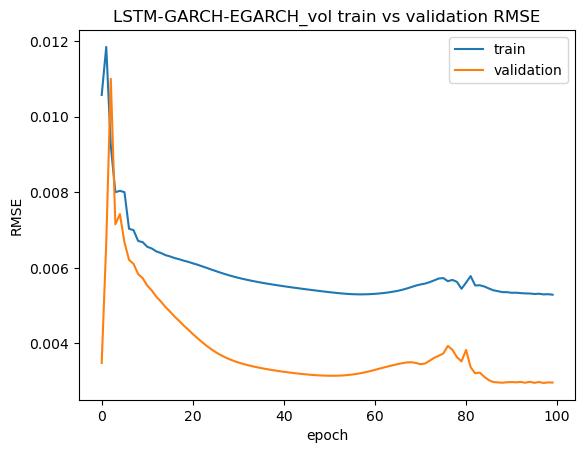

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
/nRMSE:/n
0.0031248178911459324
/nHMAE: 0.85
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [46]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'egarch_vol', 'historical_volatility', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=128,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH-EGARCH_pred_actual_values_E.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

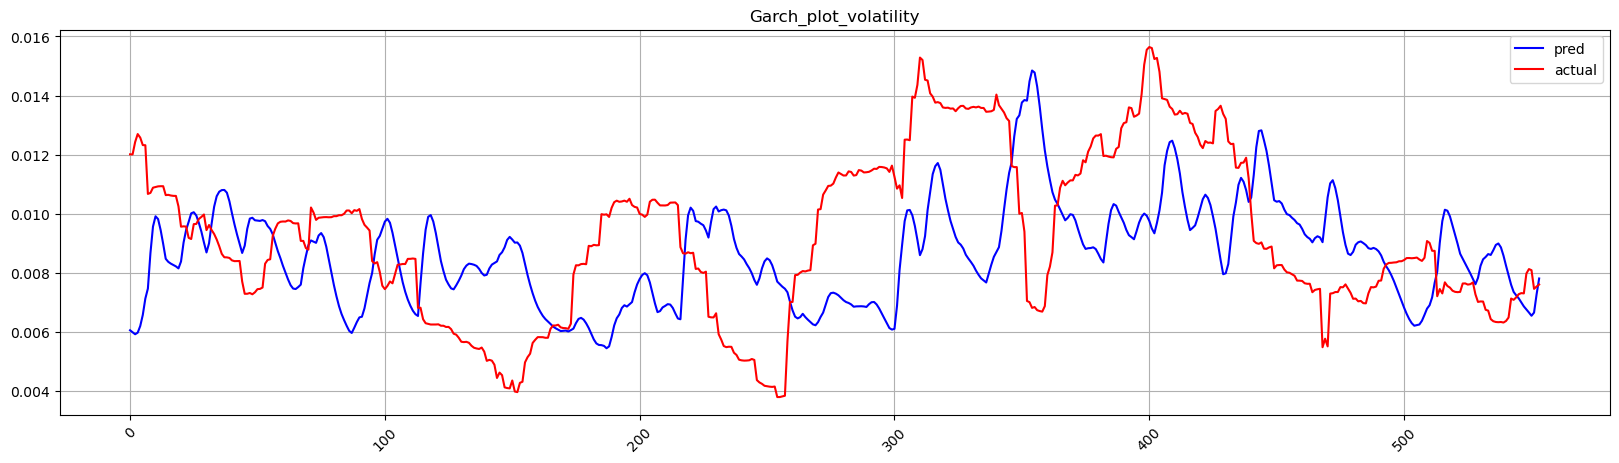

In [47]:
# df_plot = pd.read_csv('GARCH-EGARCH_pred_actual_values_B_1.csv')

# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,5))
# plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
# plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

# plt.title('Garch_plot_volatility')

# plt.xticks(rotation=45)
# plt.grid(True)

# plt.legend()
# plt.show()

X_train: (6534, 42, 7) Y_train: (6534, 1)
X_test: (554, 42, 7) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 4.4039e-04 - root_mean_squared_error: 0.0205 - val_loss: 8.8537e-05 - val_root_mean_squared_error: 0.0094
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 4.3776e-04 - root_mean_squared_error: 0.0205 - val_loss: 1.6420e-04 - val_root_mean_squared_error: 0.0128
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - loss: 8.4436e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.3293e-05 - val_root_mean_squared_error: 0.0036
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 1.4931e-04 - root_mean_squared_error: 0.0122 - val_loss: 4.9538e-05 - val_root_mean_squared_error: 0.0070
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.3699e-04 - root_mean_squared_error: 0.0114 - val_loss: 3.0905e-05 - val_root_mean_squared_error: 0.0056
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 7.8180e-05 - root_mean_squared_error

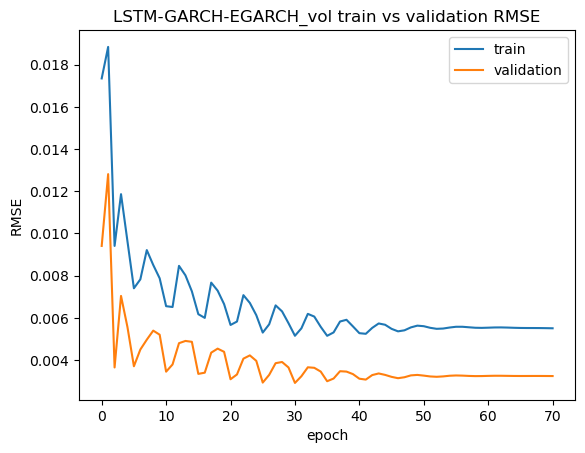

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
/nRMSE:/n
0.0030846058938956006
/nHMAE: 0.86
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


ValueError: No engine for filetype: 'csv'

In [48]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'egarch_vol', 'historical_volatility', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=512,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH-EGARCH_pred_actual_values_F.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

In [49]:
def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH-EGARCH_pred_actual_values_F.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step


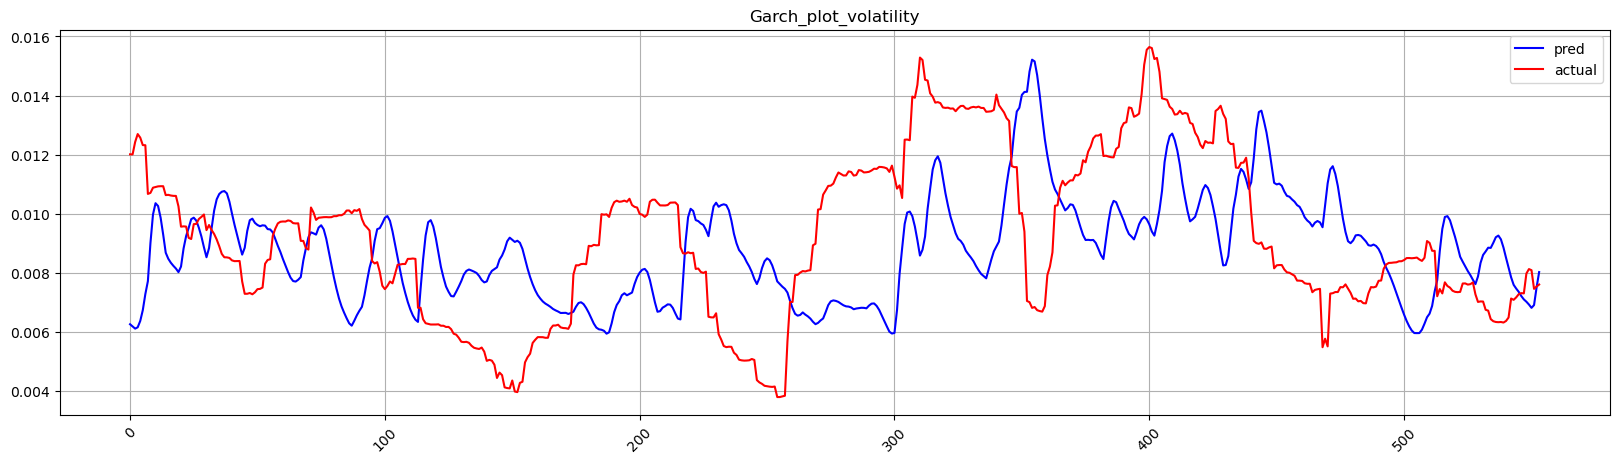

In [50]:
df_plot = pd.read_csv('GARCH-EGARCH_pred_actual_values_F_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

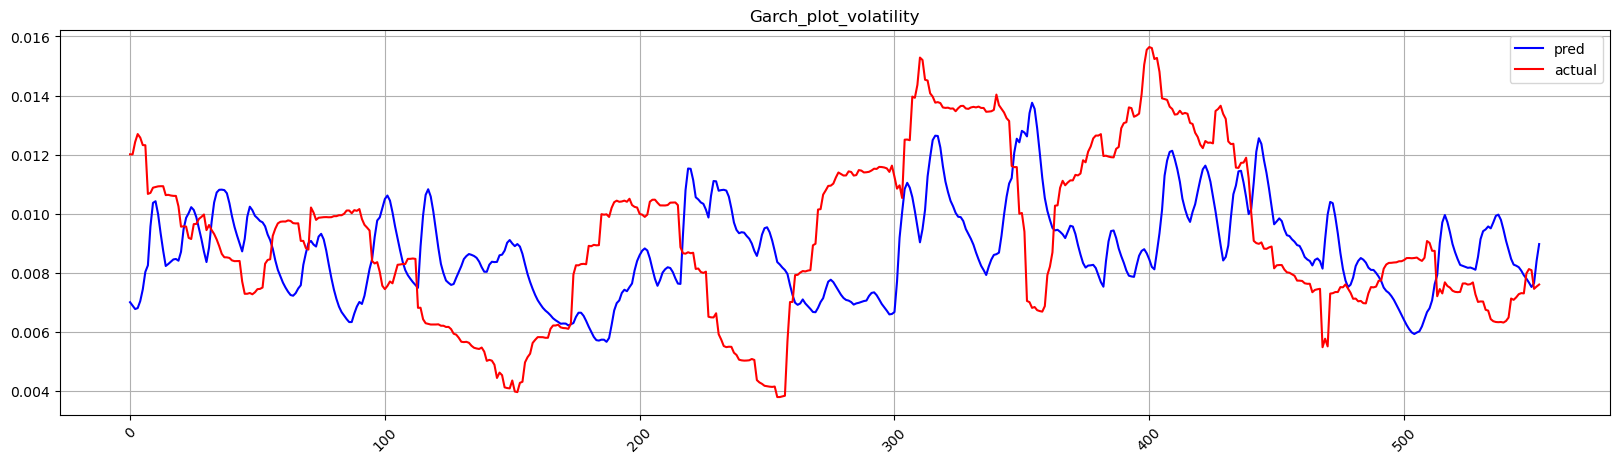

In [51]:
df_plot = pd.read_csv('GARCH-EGARCH_pred_actual_values_D_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

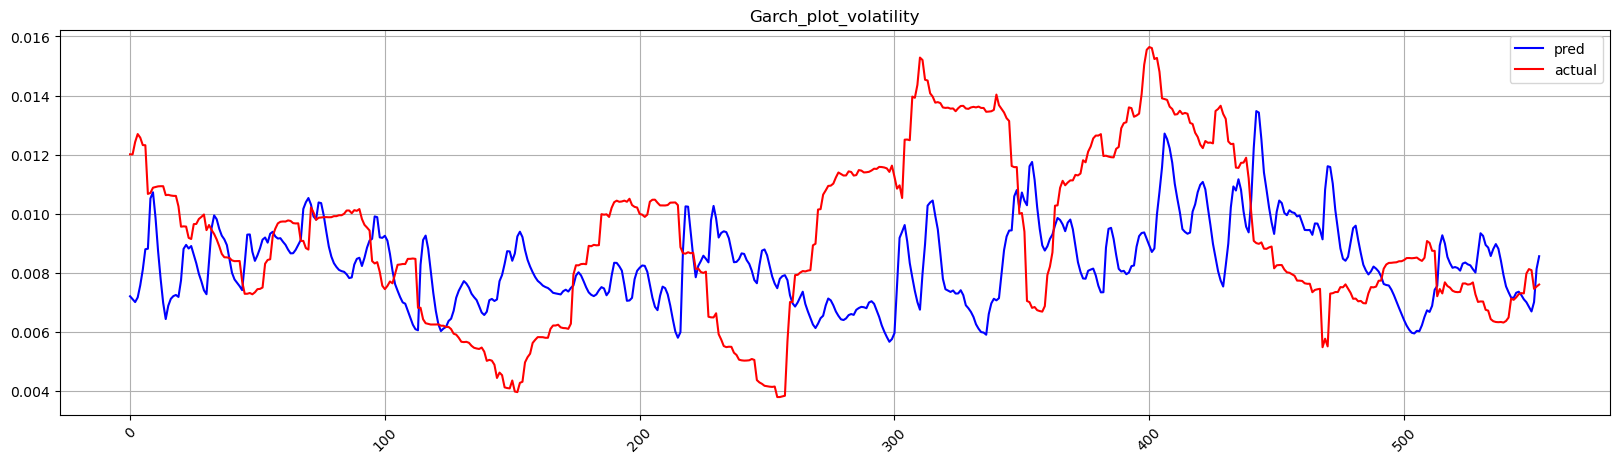

In [52]:
df_plot = pd.read_csv('GARCH-EGARCH_pred_actual_values_E_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

# EGARCH

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 4.9825e-04 - root_mean_squared_error: 0.0222 - val_loss: 7.4775e-05 - val_root_mean_squared_error: 0.0086
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 1.5029e-04 - root_mean_squared_error: 0.0121 - val_loss: 2.1535e-05 - val_root_mean_squared_error: 0.0046
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 1.5783e-04 - root_mean_squared_error: 0.0124 - val_loss: 1.0568e-04 - val_root_mean_squared_error: 0.0103
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 3.5108e-04 - root_mean_squared_error: 0.0184 - val_loss: 2.7133e-05 - val_root_mean_squared_error: 0.0052
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.0210e-04 - root_mean_squared_error: 0.0140 - val_loss: 2.1729e-05 - val_root_mean_squared_error: 0.0047
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 3.1816e-04 - root_mean_squared_error

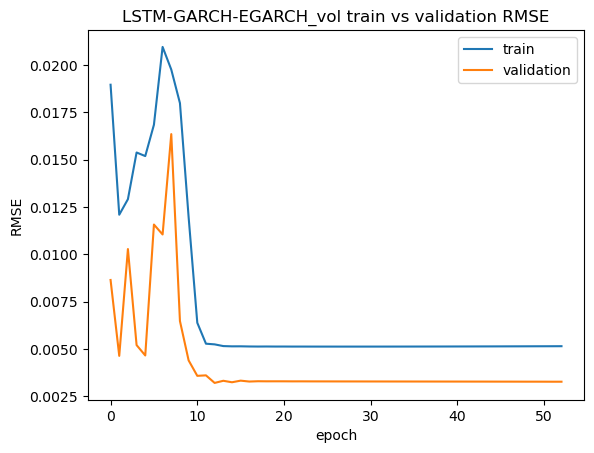

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
/nRMSE:/n
0.0030302168315200655
/nHMAE: 0.85
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step


In [53]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['egarch_vol', 'historical_volatility', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=512,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('EGARCH_pred_actual_values_A.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 4.7614e-04 - root_mean_squared_error: 0.0217 - val_loss: 1.1493e-04 - val_root_mean_squared_error: 0.0107
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 3.4625e-04 - root_mean_squared_error: 0.0180 - val_loss: 2.3256e-05 - val_root_mean_squared_error: 0.0048
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.7031e-04 - root_mean_squared_error: 0.0163 - val_loss: 9.9777e-05 - val_root_mean_squared_error: 0.0100
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 2.7266e-04 - root_mean_squared_error: 0.0161 - val_loss: 3.8308e-05 - val_root_mean_squared_error: 0.0062
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.8227e-04 - root_mean_squared_error: 0.0134 - val_loss: 3.1251e-05 - val_root_mean_squared_error: 0.0056
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.4671e-04 - root_mean_squared_error

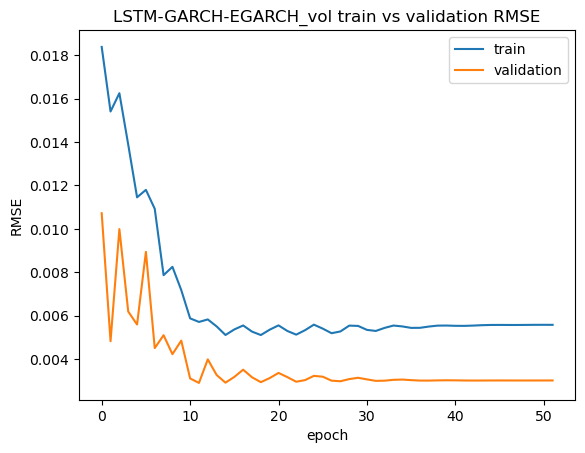

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step
/nRMSE:/n
0.00312150791980304
/nHMAE: 0.86
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


In [54]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['egarch_vol', 'historical_volatility', 'CBOE_VIX_vol', 'KOSPI200_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=512,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('EGARCH_pred_actual_values_B.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 5.3775e-04 - root_mean_squared_error: 0.0231 - val_loss: 1.2475e-04 - val_root_mean_squared_error: 0.0112
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 3.0390e-04 - root_mean_squared_error: 0.0169 - val_loss: 1.2936e-05 - val_root_mean_squared_error: 0.0036
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.3772e-04 - root_mean_squared_error: 0.0154 - val_loss: 9.3901e-05 - val_root_mean_squared_error: 0.0097
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 3.0298e-04 - root_mean_squared_error: 0.0171 - val_loss: 7.5204e-06 - val_root_mean_squared_error: 0.0027
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - loss: 7.3886e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.0144e-05 - val_root_mean_squared_error: 0.0045
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 2.1465e-04 - root_mean_squared_error

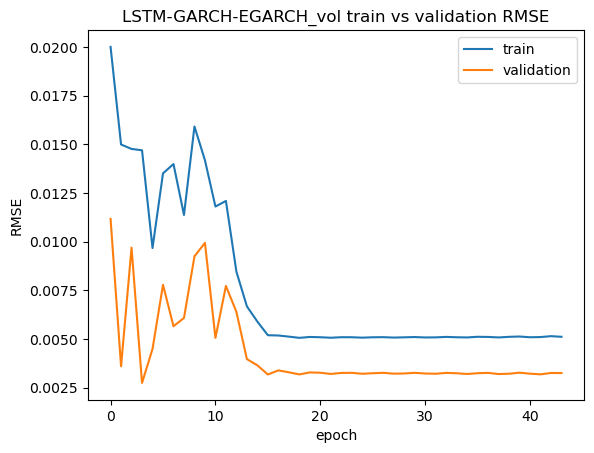

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
/nRMSE:/n
0.0030610141461449815
/nHMAE: 0.85
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step


In [55]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['egarch_vol', 'historical_volatility', 'CBOE_VIX_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=512,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('EGARCH_pred_actual_values_C.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 6.0706e-04 - root_mean_squared_error: 0.0245 - val_loss: 8.2738e-05 - val_root_mean_squared_error: 0.0091
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 1.5169e-04 - root_mean_squared_error: 0.0121 - val_loss: 3.1798e-05 - val_root_mean_squared_error: 0.0056
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.1734e-04 - root_mean_squared_error: 0.0107 - val_loss: 4.3992e-05 - val_root_mean_squared_error: 0.0066
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 1.2390e-04 - root_mean_squared_error: 0.0110 - val_loss: 1.6345e-05 - val_root_mean_squared_error: 0.0040
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 1.3085e-04 - root_mean_squared_error: 0.0111 - val_loss: 1.9112e-05 - val_root_mean_squared_error: 0.0044
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 1.1663e-04 - root_mean_squared_error

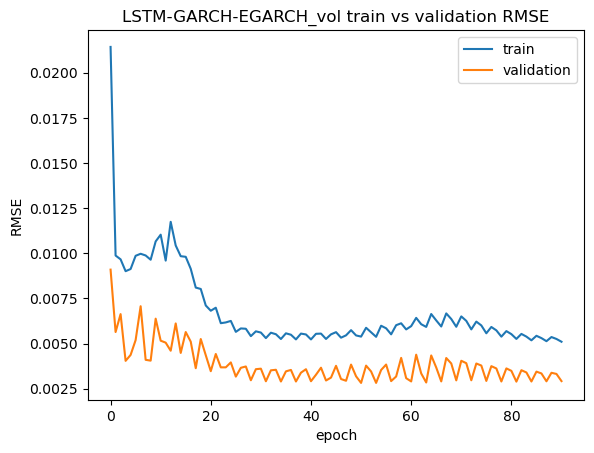

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
/nRMSE:/n
0.0030674885078274365
/nHMAE: 0.88
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step


In [56]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['egarch_vol', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=512,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH-EGARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('EGARCH_pred_actual_values_D.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

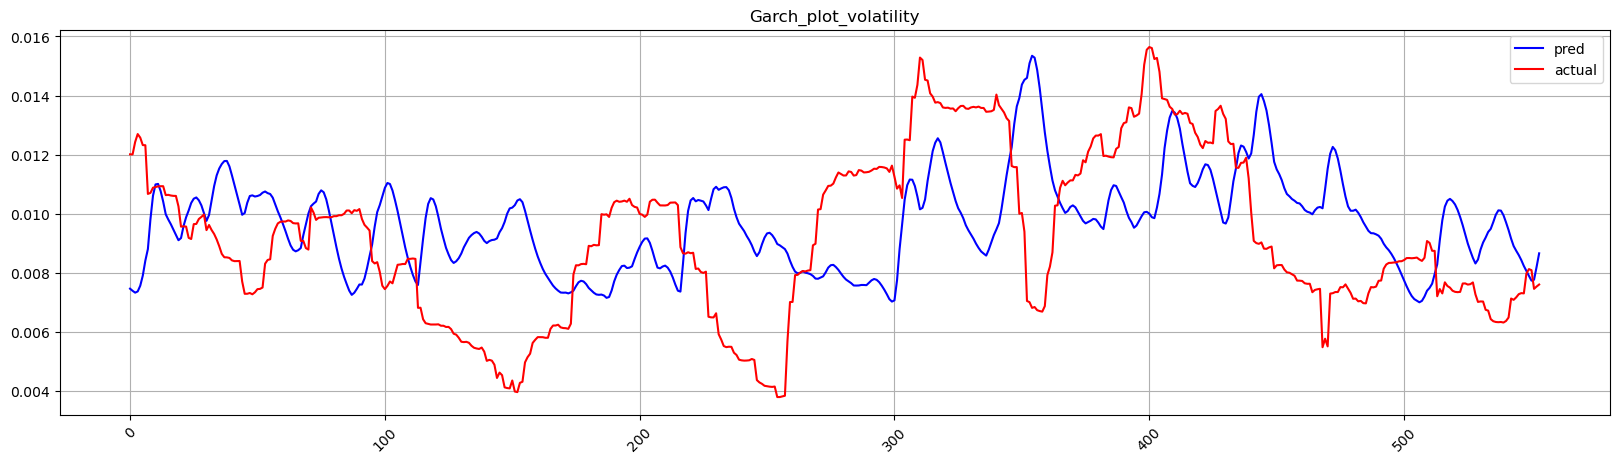

In [57]:
df_plot = pd.read_csv('EGARCH_pred_actual_values_A_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

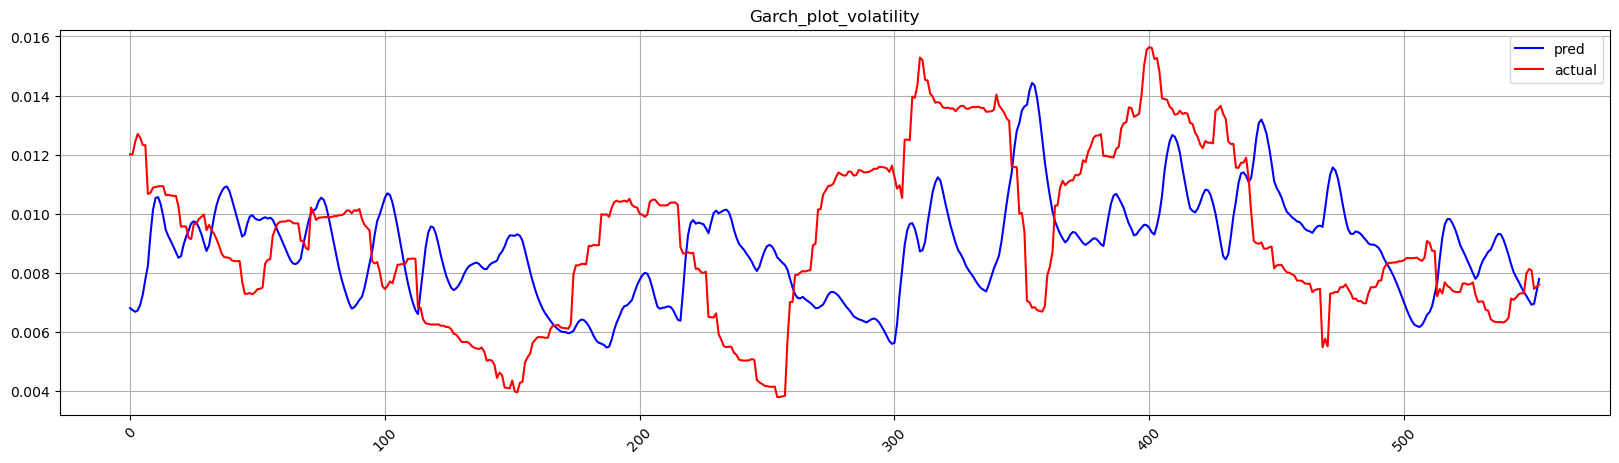

In [58]:
df_plot = pd.read_csv('EGARCH_pred_actual_values_B_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

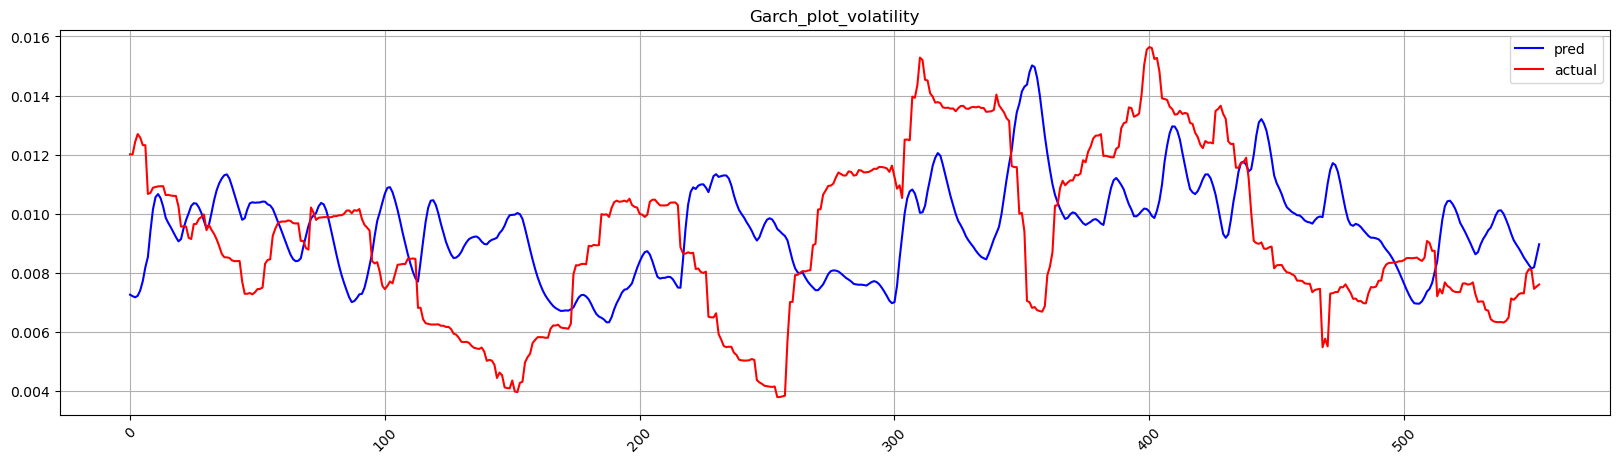

In [59]:
df_plot = pd.read_csv('EGARCH_pred_actual_values_C_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

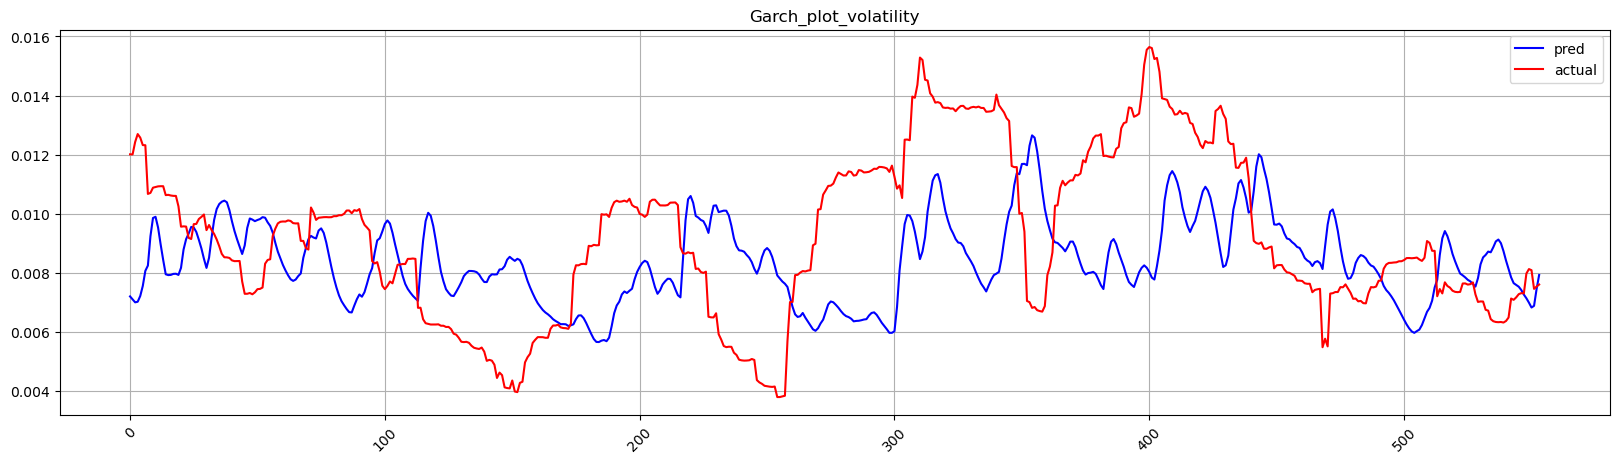

In [60]:
df_plot = pd.read_csv('EGARCH_pred_actual_values_D_1.csv')

import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(df_plot['Prediction_y'], linestyle='-', color='blue', label='pred')
plt.plot(df_plot['Actual_y'], linestyle='-', color='red', label='actual')

plt.title('Garch_plot_volatility')

plt.xticks(rotation=45)
plt.grid(True)

plt.legend()
plt.show()

# GARCH

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 491ms/step - loss: 1.4131e-04 - root_mean_squared_error: 0.0118 - val_loss: 1.8075e-05 - val_root_mean_squared_error: 0.0043
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 530ms/step - loss: 1.5124e-04 - root_mean_squared_error: 0.0122 - val_loss: 3.2837e-05 - val_root_mean_squared_error: 0.0057
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 647ms/step - loss: 2.5701e-04 - root_mean_squared_error: 0.0156 - val_loss: 8.2992e-05 - val_root_mean_squared_error: 0.0091
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - loss: 7.9073e-05 - root_mean_squared_error: 0.0088 - val_loss: 1.6410e-05 - val_root_mean_squared_error: 0.0041
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 487ms/step - loss: 6.1415e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.0270e-05 - val_root_mean_squared_error: 0.0055
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 25s 483ms/step - loss: 7.3193e-05 - root_

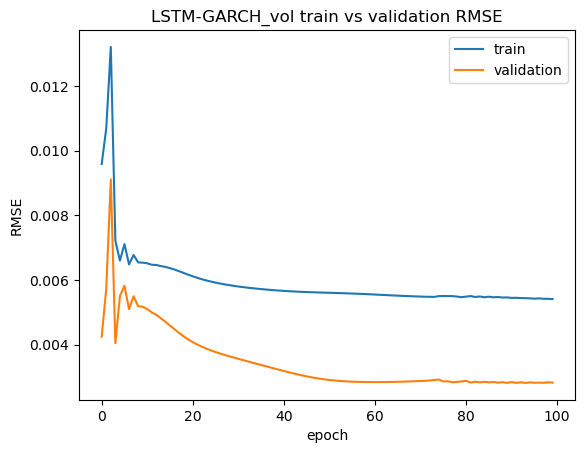

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
/nRMSE:/n
0.003198986154648736
/nHMAE: 0.89
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [61]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=128,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH_pred_actual_values_A.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 4) Y_train: (6534, 1)
X_test: (554, 42, 4) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 514ms/step - loss: 1.1635e-04 - root_mean_squared_error: 0.0106 - val_loss: 1.5283e-05 - val_root_mean_squared_error: 0.0039
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 509ms/step - loss: 8.6445e-05 - root_mean_squared_error: 0.0092 - val_loss: 1.2835e-05 - val_root_mean_squared_error: 0.0036
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 496ms/step - loss: 9.4817e-05 - root_mean_squared_error: 0.0096 - val_loss: 2.0371e-05 - val_root_mean_squared_error: 0.0045
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - loss: 7.6246e-05 - root_mean_squared_error: 0.0086 - val_loss: 2.4883e-05 - val_root_mean_squared_error: 0.0050
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 494ms/step - loss: 6.1312e-05 - root_mean_squared_error: 0.0077 - val_loss: 3.6916e-05 - val_root_mean_squared_error: 0.0061
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 501ms/step - loss: 6.9574e-05 - root_

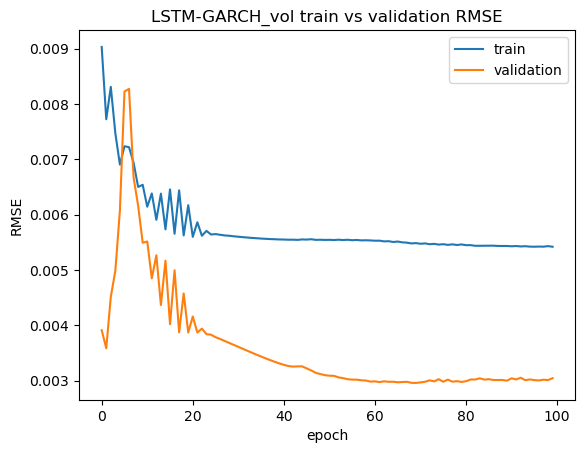

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
/nRMSE:/n
0.003358875736810143
/nHMAE: 0.94
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


In [62]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'KOSPI200_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=128,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH_pred_actual_values_B.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 4) Y_train: (6534, 1)
X_test: (554, 42, 4) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 510ms/step - loss: 2.6476e-04 - root_mean_squared_error: 0.0160 - val_loss: 2.7860e-05 - val_root_mean_squared_error: 0.0053
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 504ms/step - loss: 1.9452e-04 - root_mean_squared_error: 0.0137 - val_loss: 1.1892e-05 - val_root_mean_squared_error: 0.0034
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 26s 494ms/step - loss: 4.9511e-05 - root_mean_squared_error: 0.0069 - val_loss: 8.3299e-06 - val_root_mean_squared_error: 0.0029
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 534ms/step - loss: 8.5375e-05 - root_mean_squared_error: 0.0091 - val_loss: 1.0819e-05 - val_root_mean_squared_error: 0.0033
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 614ms/step - loss: 4.5194e-05 - root_mean_squared_error: 0.0066 - val_loss: 8.0786e-06 - val_root_mean_squared_error: 0.0028
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 590ms/step - loss: 6.7959e-05 - root_

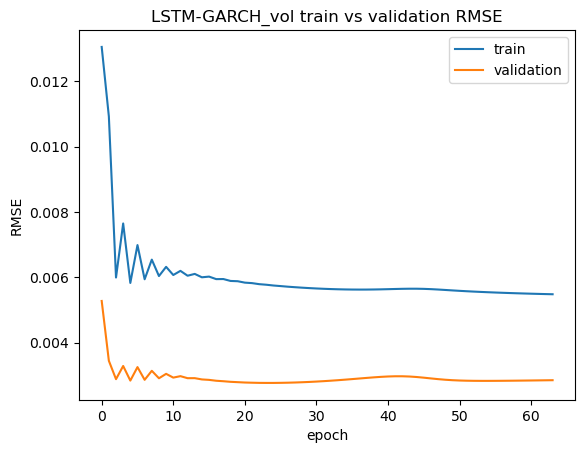

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
/nRMSE:/n
0.0031151157364138803
/nHMAE: 0.89
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


In [63]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'CBOE_VIX_vol', 'KOSPI200_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=128,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH_pred_actual_values_C.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 492ms/step - loss: 2.6550e-04 - root_mean_squared_error: 0.0159 - val_loss: 2.3601e-05 - val_root_mean_squared_error: 0.0049
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 675ms/step - loss: 2.1888e-04 - root_mean_squared_error: 0.0145 - val_loss: 2.5262e-05 - val_root_mean_squared_error: 0.0050
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 674ms/step - loss: 9.3547e-05 - root_mean_squared_error: 0.0095 - val_loss: 3.1591e-05 - val_root_mean_squared_error: 0.0056
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 755ms/step - loss: 6.6784e-05 - root_mean_squared_error: 0.0081 - val_loss: 1.7164e-05 - val_root_mean_squared_error: 0.0041
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 626ms/step - loss: 7.0081e-05 - root_mean_squared_error: 0.0082 - val_loss: 2.4048e-05 - val_root_mean_squared_error: 0.0049
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 567ms/step - loss: 8.5954e-05 - root_

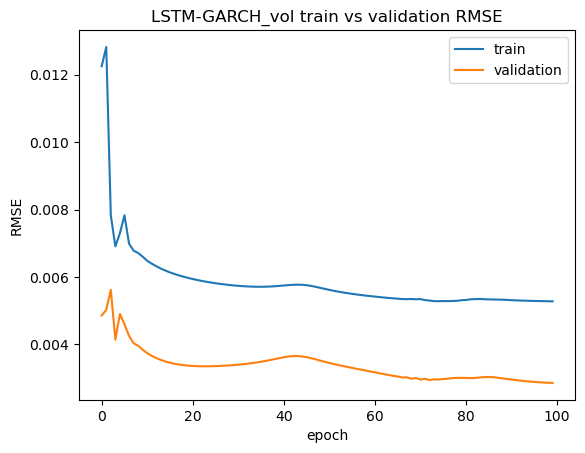

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
/nRMSE:/n
0.0031153617633355975
/nHMAE: 0.87
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step


In [64]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'historical_volatility', 'CBOE_VIX_vol', 'USD_KRW_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=128,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH_pred_actual_values_D.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)

X_train: (6534, 42, 5) Y_train: (6534, 1)
X_test: (554, 42, 5) Y_test: (554, 1)
Epoch 1/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 589ms/step - loss: 1.4002e-04 - root_mean_squared_error: 0.0117 - val_loss: 1.6325e-05 - val_root_mean_squared_error: 0.0040
Epoch 2/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 569ms/step - loss: 1.4003e-04 - root_mean_squared_error: 0.0117 - val_loss: 2.9455e-05 - val_root_mean_squared_error: 0.0054
Epoch 3/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 554ms/step - loss: 2.2612e-04 - root_mean_squared_error: 0.0148 - val_loss: 8.6716e-05 - val_root_mean_squared_error: 0.0093
Epoch 4/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 29s 560ms/step - loss: 8.1150e-05 - root_mean_squared_error: 0.0089 - val_loss: 1.2055e-05 - val_root_mean_squared_error: 0.0035
Epoch 5/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 28s 544ms/step - loss: 5.8653e-05 - root_mean_squared_error: 0.0075 - val_loss: 3.8833e-05 - val_root_mean_squared_error: 0.0062
Epoch 6/100
52/52 ━━━━━━━━━━━━━━━━━━━━ 33s 636ms/step - loss: 8.5464e-05 - root_

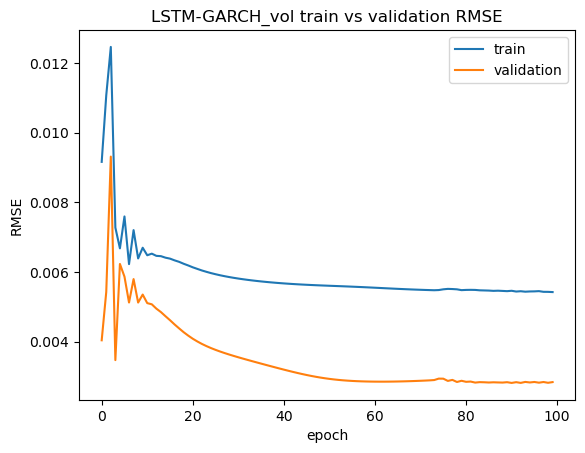

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step
/nRMSE:/n
0.003178388677462171
/nHMAE: 0.88
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [65]:
#%%

# 데이터 로드
df = pd.read_csv('finally_para_py_GARCH1_2_BTC_CBOE_VIX_KOSPI200_USDKRW.csv')
#df.head()

#%%
# 'index' 열의 datetime 변환 및 인덱스 설정
df['index'] = pd.to_datetime(df['datetime'])
df.set_index(df['index'], inplace=True)

# garch 파라미터 Split
X_garch = df[['garch_vol', 'CBOE_VIX_vol', 'USD_KRW_vol', 'KOSPI200_vol', 'predicted_volatility']].values
# 경제지표 vol :  'CBOE_VIX_vol', 'KOSPI200_vol', 'USD_KRW_vol' , 종가 있/없 비교 : 'close'
y = df['Next_7_Days_Volatility'].values

def dataset_split(x_set,y_set):
    # 데이터 분할 인덱스 설정
    train_end = df.index.get_loc('2022-12-31 21:00:00')
    valid_end = df.index.get_loc('2023-12-31 21:00:00')

    # 훈련 데이터셋
    train_x = x_set[:train_end+1]
    train_y = y_set[:train_end+1]

    # 검증 데이터셋
    valid_x = x_set[train_end+1:valid_end+1]
    valid_y = y_set[train_end+1:valid_end+1]

    # 테스트 데이터셋
    test_x = x_set[valid_end+1:]
    test_y = y_set[valid_end+1:]

    return train_x, train_y, valid_x, valid_y, test_x, test_y

train_X_garch, train_y_garch, valid_X_garch, valid_y_garch, test_X_garch, test_y_garch = dataset_split(X_garch, y)

# 스케일러 초기화
scaler_x = MinMaxScaler(feature_range=(0, 1))

# 훈련 데이터셋에 fit 후 transform
train_X_scaled = scaler_x.fit_transform(train_X_garch)

# 검증 및 테스트 데이터셋에는 transform만 적용
valid_X_scaled = scaler_x.transform(valid_X_garch)
test_X_scaled = scaler_x.transform(test_X_garch)

## X / Y Split

sequence = 42
X_train, Y_train = [], []
for index in range(len(train_X_scaled) - sequence):
    X_train.append(np.array(train_X_scaled[index: index + sequence]))
    Y_train.append(np.ravel(train_y_garch[index + sequence:index + sequence + 1]))
X_train, Y_train = np.array(X_train), np.array(Y_train)

X_valid, Y_valid = [], []
for index in range(len(valid_X_scaled) - sequence):
    X_valid.append(np.array(valid_X_scaled[index: index + sequence]))
    Y_valid.append(np.ravel(valid_y_garch[index + sequence:index + sequence + 1]))
X_valid, Y_valid = np.array(X_valid), np.array(Y_valid)


X_test, Y_test = [], []
for index in range(len(test_X_scaled) - sequence):
    X_test.append(np.array(test_X_scaled[index: index + sequence]))
    Y_test.append(np.ravel(test_y_garch[index + sequence:index + sequence + 1]))
X_test, Y_test = np.array(X_test), np.array(Y_test)

train_y_garch =  Y_train
valid_y_garch = Y_valid
test_y_garch =  Y_test

## Retype and Reshape
train_X_garch = X_train.reshape(X_train.shape[0], sequence, -1)
valid_X_garch = X_valid.reshape(X_valid.shape[0], sequence, -1)
test_X_garch = X_test.reshape(X_test.shape[0], sequence, -1)

print('X_train:', train_X_garch.shape, 'Y_train:', train_y_garch.shape)
print('X_test:', test_X_garch.shape, 'Y_test:', test_y_garch.shape)

#%%
class HMAELoss(Loss):
    def __init__(self, name='hmae_loss'):
        super(HMAELoss, self).__init__(name=name)

    def call(self, y_true, y_pred):
        error = tf.abs(y_true - y_pred)
        variance = tf.math.reduce_variance(y_true - y_pred, axis=-1)
        hmae = tf.reduce_mean(error / tf.sqrt(variance))
        return hmae

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#%%
#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose = 1)

# %%
def build_model():
    inputLSTM_GARCH_EGARCH = tf.keras.layers.Input(shape=(train_X_garch.shape[1], train_X_garch.shape[2]))
    y = tf.keras.layers.LSTM(units=500, return_sequences=True)(inputLSTM_GARCH_EGARCH)
    y = tf.keras.layers.LSTM(units=500)(y)
    y = tf.keras.layers.Dense(1)(y)

    model = tf.keras.Model(inputs=inputLSTM_GARCH_EGARCH, outputs=y)

    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                  loss=tf.keras.losses.MeanSquaredError(),
                  metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

#epoch 수 최적화 위해 stop_early를 callabacks로 사용
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=40, verbose=1)


model = build_model()
history = model.fit(train_X_garch, train_y_garch,
                   epochs=100,
                   validation_data=(valid_X_garch, valid_y_garch),
                   batch_size=128,
                   callbacks=[stop_early],
                   shuffle=False)

#%%

def model_RMSE_plot(hist_model, model_name):
    plt.plot(hist_model.history['root_mean_squared_error'])
    plt.plot(hist_model.history['val_root_mean_squared_error'])
    plt.title('{} train vs validation RMSE'.format(model_name))
    plt.ylabel('RMSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()


def printing_out_results_of_a_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()

    # # R2 score 출력 # R2 빼기로 함
    # print("R2 score:/n")
    # print(('{:.2f}'.format((60 * (r2_score(y_test, y_pred))))) + " %")

    # RMSE 출력
    print("/nRMSE:/n")
    print(math.sqrt(mean_squared_error(y_test, y_pred)))

    # # Mean Squared Error 출력 # MSE는 RMSE와 겹쳐서 빼기로 함
    # print("/nMean Squared Error:/n")
    # print(mean_squared_error(y_test, y_pred))

    # HMAE 출력
    hmae_loss = HMAELoss()
    hmae_value = hmae_loss(y_test, y_pred)
    print(f"/nHMAE: {hmae_value:.2f}")

model_RMSE_plot(history, "LSTM-GARCH_vol") #경제지표 volatility 쓰면 LSTM-GARCH_vol 추가
printing_out_results_of_a_model(model,test_X_garch, test_y_garch )

def result_to_excel(model, test_X_garch, test_y_garch):
    result_df = pd.DataFrame(columns=['Prediction_y', 'Actual_y'])

    for ind, prediction in enumerate(model.predict(test_X_garch)):
        result_df.loc[ind] = [prediction[0], test_y_garch[ind]]

    result_df.to_excel('GARCH_pred_actual_values_E.xlsx', index=False)

result_to_excel(model, test_X_garch, test_y_garch)